# Modelagem e Análise de Pequenos Sinais do Conversor Buck

**Autor:** (Rômulo Nunes/PPGEE-UFC)


---

## 1. Objetivo

Este notebook demonstra o processo de modelagem dinâmica de um conversor Buck (abaixador) operando em Modo de Condução Contínua (MCC). O objetivo principal é derivar, passo a passo, a função de transferência (FT) canônica de controle, que relaciona a tensão de saída ($\tilde{v}_o$) com a variação na razão cíclica ($\tilde{d}$):

$$G_v(s) = \frac{\tilde{v}_o(s)}{\tilde{d}(s)}$$

A nomenclatura utilizada neste notebook seguirá a do artigo de referência (Berger, et al.) para consistência.

## 2. Metodologia: Média por Espaço de Estados

Conversores de potência são sistemas comutados e, portanto, intrinsecamente não-lineares e variantes no tempo. Para aplicar as ferramentas clássicas de análise e projeto de controle (como Transformada de Laplace, diagramas de Bode, etc.), é necessário obter um modelo linear e invariante no tempo (LIT) que aproxime o comportamento do sistema em torno de um ponto de operação.

A metodologia utilizada será a **Média por Espaço de Estados (State-Space Averaging)**, que consiste nos seguintes passos:

1. **Etapa 1: Modelo (Chave ON)** - Definir as equações de estado lineares para a primeira topologia (chave fechada, tempo $DT$).
2. **Etapa 2: Modelo (Chave OFF)** - Definir as equações de estado lineares para a segunda topologia (chave aberta, tempo $(1-D)T$).
3. **Etapa 3: Modelo Médio (Averaging)** - Ponderar as matrizes de estado ($A_1, A_2$) pela razão cíclica $D$ para obter um modelo não-linear médio.
4. **Etapa 4: Linearização (Pequenos Sinais)** - Linearizar o modelo médio em torno de um ponto de operação DC ($X, U, D$) para obter o modelo AC ($\tilde{x}, \tilde{u}, \tilde{d}$).
5. **Etapa 5: Obtenção de G(s)** - Aplicar a Transformada de Laplace no modelo AC para encontrar as funções de transferência de interesse.

## 3. Definição do Modelo

### 3.1. Circuito Analisado

Para um modelo de alta fidelidade, adequado para o projeto de compensadores, analisaremos o conversor Buck incluindo a **Resistência Série Equivalente (ESR)** do capacitor de saída, $R_C$. A inclusão deste componente é fundamental, pois introduz um zero de alta frequência na FT, essencial para a análise de estabilidade da malha.

> *O circuito consiste em: Fonte $E$, Chave (S), Diodo (D_F), Indutor ($L$), Capacitor ($C$), ESR do Capacitor ($R_C$) e Carga ($R_L$).*
> 
> (Aqui seria um local ideal no relatório para inserir uma imagem do diagrama esquemático do circuito.)

### 3.2. Definição dos Vetores (Estado, Entrada, Saída)

O sistema é de segunda ordem, pois possui dois elementos armazenadores de energia ($L$ e $C$) cujos estados não podem ser combinados.

* **Vetor de Estados ($x$)**: Escolhemos as variáveis que descrevem a energia do sistema.
 $$x = \begin{bmatrix} i_L \\ v_C \end{bmatrix}$$
 Onde $i_L$ é a corrente no indutor e $v_C$ é a tensão *apenas* no ramo do capacitor (sem a ESR).

* **Vetor de Entradas ($u$)**: A fonte de tensão de entrada.
 $$u = [E]$$

* **Variável de Saída ($y$)**: A tensão de saída $v_o$, que é a tensão sobre a carga $R_L$. Esta tensão é a soma da tensão no capacitor ($v_C$) e da tensão na ESR ($v_{R_C}$).
 $$y = v_o = v_C + v_{R_C}$$

Para encontrar a equação de saída em termos dos estados, analisamos a corrente no capacitor, $i_C$. Por KCL no nó de saída, $i_L = i_C + i_R$.
A tensão de saída $v_o$ pode ser expressa de duas formas:
1. $v_o = v_C + R_C \cdot i_C$
2. $v_o = R_L \cdot i_R = R_L \cdot (i_L - i_C)$

Igualando e resolvendo para $i_C$, temos: $i_C = \frac{R_L}{R_L+R_C} i_L - \frac{1}{R_L+R_C} v_C$.
Substituindo $i_C$ na equação (1), obtemos $y = v_o$ em função apenas dos estados $i_L$ e $v_C$:

$$y = v_o = \left( \frac{R_L \cdot R_C}{R_L + R_C} \right) i_L + \left( \frac{R_L}{R_L + R_C} \right) v_C$$

Esta será nossa **Matriz de Saída (C)**.

---

In [3]:

pip install numpy matplotlib scipy control

# ## Célula 3: Setup de Simulação e Definições Simbólicas

# Importa a biblioteca SymPy para matemática simbólica
import sympy as sp

# Inicializa a impressão "pretty print" para equações bem formatadas
sp.init_printing()

print("Ambiente SymPy inicializado.\n")

# --- Definição das Variáveis Simbólicas (Padrão do Artigo) ---

# Variáveis do domínio de Laplace e tempo
s, t = sp.symbols('s t')

# Componentes do circuito (reais e positivos)
L, C, R_L, R_C = sp.symbols('L C R_L R_C', positive=True)

# Entradas e Ponto de Operação
E, D = sp.symbols('E D', positive=True)

# Matriz Identidade 2x2 (para cálculos de FT)
I = sp.eye(2)

print("Variáveis simbólicas definidas:")
print(f"Componentes: L, C, R_L (Carga), R_C (ESR)")
print(f"Entradas: E (Tensão de Entrada), D (Razão Cíclica)")
print(f"Domínio: s, t")

Ambiente SymPy inicializado.

Variáveis simbólicas definidas:
Componentes: L, C, R_L (Carga), R_C (ESR)
Entradas: E (Tensão de Entrada), D (Razão Cíclica)
Domínio: s, t


## 4. Derivação do Modelo em Espaço de Estados

### 4.1. Etapa 1: Modelo (Chave ON - Intervalo $DT$)

Durante o primeiro intervalo, quando a chave S está **fechada** (tempo $t \in [0, DT]$), a fonte de entrada $E$ está conectada ao indutor. O diodo $D_F$ está reversamente polarizado e, portanto, aberto.

O modelo de circuito para esta etapa é:
* Fonte $E$ conectada ao indutor $L$.
* O indutor $L$ está conectado ao nó de saída.
* O nó de saída se divide em dois ramos paralelos:
 1. O ramo da carga $R_L$.
 2. O ramo do capacitor $C$ em série com sua ESR $R_C$.

neste relatório analisa-se derivar as equações de estado $\dot{x} = A_1 x + B_1 u$, onde $x = [i_L, v_C]^T$ e $u = [E]$.

---

**1. Equação do Indutor ($\dot{i_L}$):**
Aplicamos a Lei das Tensões de Kirchhoff (KVL) na malha de entrada:
$$v_L = E - v_o$$
$$L \frac{di_L}{dt} = E - v_o$$

Precisamos de $v_o$ em termos dos estados $x$. Como vimos na Seção 3.2, a tensão de saída $v_o$ é:
$$v_o = \left( \frac{R_L R_C}{R_L + R_C} \right) i_L + \left( \frac{R_L}{R_L + R_C} \right) v_C$$

Substituindo $v_o$ na equação do indutor:
$$L \frac{di_L}{dt} = E - \left[ \left( \frac{R_L R_C}{R_L + R_C} \right) i_L + \left( \frac{R_L}{R_L + R_C} \right) v_C \right]$$

Isolando $\frac{di_L}{dt}$ (a primeira linha de $\dot{x}$):
$$\frac{di_L}{dt} = - \frac{1}{L} \left( \frac{R_L R_C}{R_L + R_C} \right) i_L - \frac{1}{L} \left( \frac{R_L}{R_L + R_C} \right) v_C + \frac{1}{L} E$$

---

**2. Equação do Capacitor ($\dot{v_C}$):**
Aplicamos a Lei das Correntes de Kirchhoff (KCL) no nó de saída. A corrente $i_C$ é a corrente que entra no ramo do capacitor:
$$C \frac{dv_C}{dt} = i_C$$

Como visto na Seção 3.2, $i_C$ em termos dos estados é:
$$i_C = \left( \frac{R_L}{R_L + R_C} \right) i_L - \frac{1}{R_L + R_C} v_C$$

Substituindo $i_C$ na equação do capacitor:
$$C \frac{dv_C}{dt} = \left( \frac{R_L}{R_L + R_C} \right) i_L - \frac{1}{R_L + R_C} v_C$$

Isolando $\frac{dv_C}{dt}$ (a segunda linha de $\dot{x}$):
$$\frac{dv_C}{dt} = \frac{1}{C} \left( \frac{R_L}{R_L + R_C} \right) i_L - \frac{1}{C(R_L + R_C)} v_C + 0 \cdot E$$

---

**3. Matrizes $A_1$ e $B_1$:**
Combinando as duas equações em forma matricial $\dot{x} = A_1 x + B_1 u$:

$$ \begin{bmatrix} \dot{i_L} \\ \dot{v_C} \end{bmatrix} = 
\begin{bmatrix} 
-\frac{1}{L} \left( \frac{R_L R_C}{R_L + R_C} \right) & -\frac{1}{L} \left( \frac{R_L}{R_L + R_C} \right) \\
 \frac{1}{C} \left( \frac{R_L}{R_L + R_C} \right) & -\frac{1}{C(R_L + R_C)} 
\end{bmatrix}
\begin{bmatrix} i_L \\ v_C \end{bmatrix}
+
\begin{bmatrix} \frac{1}{L} \\ 0 \end{bmatrix}
[E]
$$

In [5]:
# ## Célula 4: Definição das Matrizes da Etapa 1 (Chave ON)

print("--- 4.1. Etapa 1: Modelo (Chave ON) ---")

# Para simplificar a entrada, definimos os termos R_paralelo e G_soma
R_par = (R_L * R_C) / (R_L + R_C)
R_soma_inv = 1 / (R_L + R_C)
R_div = R_L / (R_L + R_C)

# Matriz A1
A1 = sp.Matrix([
    [-R_par / L, -R_div / L],
    [R_div / C, -R_soma_inv / C]
])

# Matriz B1 (referente à entrada u = [E])
B1 = sp.Matrix([
    [1/L],
    [0]
])

print("Matriz A1 (Chave ON):")
sp.pprint(A1)

print("\nMatriz B1 (Chave ON):")
sp.pprint(B1)

--- 4.1. Etapa 1: Modelo (Chave ON) ---
Matriz A1 (Chave ON):
⎡  -R_C⋅R_L         -R_L     ⎤
⎢─────────────  ─────────────⎥
⎢L⋅(R_C + R_L)  L⋅(R_C + R_L)⎥
⎢                            ⎥
⎢     R_L            -1      ⎥
⎢─────────────  ─────────────⎥
⎣C⋅(R_C + R_L)  C⋅(R_C + R_L)⎦

Matriz B1 (Chave ON):
⎡1⎤
⎢─⎥
⎢L⎥
⎢ ⎥
⎣0⎦


### 4.2. Etapa 2: Modelo (Chave OFF - Intervalo $(1-D)T$)

Durante o segundo intervalo, quando a chave S está **aberta** (tempo $t \in [DT, T]$), a fonte $E$ é desconectada.

A corrente do indutor $i_L$ (que não pode variar instantaneamente) força o diodo de roda-livre $D_F$ a conduzir. Assumindo um diodo ideal (queda de tensão $V_D \approx 0V$), o terminal do indutor que estava conectado à chave é agora aterrado.

O modelo de circuito para esta etapa é:
* O indutor $L$ está conectado entre o terra (via $D_F$) e o nó de saída.
* O nó de saída permanece idêntico ao da Etapa 1 (carga $R_L$ em paralelo com $C$ + $R_C$).

neste relatório analisa-se derivar as equações de estado $\dot{x} = A_2 x + B_2 u$.

---

**1. Equação do Indutor ($\dot{i_L}$):**
Aplicamos KVL na malha que inclui o diodo, o indutor e o nó de saída:
$$v_L = V_{Diodo} - v_o$$
$$L \frac{di_L}{dt} = 0 - v_o$$

Substituindo a mesma expressão para $v_o$ em termos dos estados:
$$L \frac{di_L}{dt} = - \left[ \left( \frac{R_L R_C}{R_L + R_C} \right) i_L + \left( \frac{R_L}{R_L + R_C} \right) v_C \right]$$

Isolando $\frac{di_L}{dt}$:
$$\frac{di_L}{dt} = - \frac{1}{L} \left( \frac{R_L R_C}{R_L + R_C} \right) i_L - \frac{1}{L} \left( \frac{R_L}{R_L + R_C} \right) v_C + 0 \cdot E$$

*Nota: Esta é a **mesma** expressão para $\frac{di_L}{dt}$ da Etapa 1, exceto pelo termo de entrada, que agora é nulo.*

---

**2. Equação do Capacitor ($\dot{v_C}$):**
A topologia do nó de saída (onde $i_L$ se divide em $i_C$ e $i_R$) é **exatamente a mesma** da Etapa 1. A fonte $E$ não influencia este nó diretamente.

Portanto, a equação KCL e a derivada $\dot{v_C}$ são idênticas às da Etapa 1:
$$\frac{dv_C}{dt} = \frac{1}{C} \left( \frac{R_L}{R_L + R_C} \right) i_L - \frac{1}{C(R_L + R_C)} v_C + 0 \cdot E$$

---

**3. Matrizes $A_2$ e $B_2$:**
Combinando as duas equações em forma matricial $\dot{x} = A_2 x + B_2 u$:

$$ \begin{bmatrix} \dot{i_L} \\ \dot{v_C} \end{bmatrix} = 
\begin{bmatrix} 
-\frac{1}{L} \left( \frac{R_L R_C}{R_L + R_C} \right) & -\frac{1}{L} \left( \frac{R_L}{R_L + R_C} \right) \\
 \frac{1}{C} \left( \frac{R_L}{R_L + R_C} \right) & -\frac{1}{C(R_L + R_C)} 
\end{bmatrix}
\begin{bmatrix} i_L \\ v_C \end{bmatrix}
+
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
[E]
$$

**Observação Importante:** Para o conversor Buck (e apenas para caso específico do Buck), note que $A_1 = A_2$. Isso simplificará significativamente a etapa de média e linearização.

In [7]:
# ## Célula 6: Definição das Matrizes da Etapa 2 (Chave OFF)

print("--- 4.2. Etapa 2: Modelo (Chave OFF) ---")

# Matriz A2
# Conforme derivado no Markdown, A2 é idêntica a A1.
A2 = A1

# Matriz B2 (referente à entrada u = [E])
# A entrada E é desconectada do circuito.
B2 = sp.Matrix([
    [0],
    [0]
])

print("Matriz A2 (Chave OFF):")
sp.pprint(A2)

print("\nMatriz B2 (Chave OFF):")
sp.pprint(B2)

--- 4.2. Etapa 2: Modelo (Chave OFF) ---
Matriz A2 (Chave OFF):
⎡  -R_C⋅R_L         -R_L     ⎤
⎢─────────────  ─────────────⎥
⎢L⋅(R_C + R_L)  L⋅(R_C + R_L)⎥
⎢                            ⎥
⎢     R_L            -1      ⎥
⎢─────────────  ─────────────⎥
⎣C⋅(R_C + R_L)  C⋅(R_C + R_L)⎦

Matriz B2 (Chave OFF):
⎡0⎤
⎢ ⎥
⎣0⎦


### 4.3. Etapa 3: Modelo Médio (Averaging)

neste etapa, combinamos os dois modelos comutados (Etapa 1 e 2) em um único modelo médio, ponderado pela razão cíclica $D$.

As matrizes médias do sistema $\dot{x} = A x + B u$ são calculadas como:
$$A_{avg} = D \cdot A_1 + (1-D) \cdot A_2$$
$$B_{avg} = D \cdot B_1 + (1-D) \cdot B_2$$

neste relatório analisa-se aplicar esta regra aos nossos resultados:

**Cálculo de $A_{avg}$:**
Como observamos anteriormente, para o conversor Buck, $A_1 = A_2$. Isso leva a uma simplificação fundamental:
$$A_{avg} = D \cdot A_1 + (1-D) \cdot A_1 = (D + 1 - D) \cdot A_1 = A_1$$
Portanto, a matriz de dinâmica do sistema $A_{avg}$ é, na verdade, linear e independente de $D$.

**Cálculo de $B_{avg}$:**
$$B_{avg} = D \cdot \begin{bmatrix} 1/L \\ 0 \end{bmatrix} + (1-D) \cdot \begin{bmatrix} 0 \\ 0 \end{bmatrix} = \begin{bmatrix} D/L \\ 0 \end{bmatrix}$$

**Modelo Médio (Não-Linear):**
O modelo médio resultante é:
$$\dot{x} = A_1 \cdot x + \begin{bmatrix} D/L \\ 0 \end{bmatrix} \cdot E$$

Este modelo ainda é **não-linear** porque a entrada de controle $D$ é multiplicada pelo estado $E$ (se $E$ fosse um estado) e, mais importante, $D$ é uma variável de entrada.

### 4.4. Etapa 4: Linearização (Pequenos Sinais)

Agora, linearizamos o modelo médio em torno de um ponto de operação DC (ou quiescente). Assumimos que cada variável é composta por um valor DC (maiúsculo, ex: $\bar{D}$) e uma pequena perturbação AC (minúscula com til, ex: $\tilde{d}$):

* $d(t) = \bar{D} + \tilde{d}(t)$
* $e(t) = \bar{E} + \tilde{e}(t)$
* $x(t) = \bar{X} + \tilde{x}(t)$
* $y(t) = \bar{Y} + \tilde{y}(t)$

A equação geral para o modelo AC linearizado $\dot{\tilde{x}} = A \tilde{x} + B \tilde{u} + B_d \tilde{d}$ é:
$$\dot{\tilde{x}} = (A_{avg}) \tilde{x} + (B_{avg}) \tilde{u} + \left[ (A_1 - A_2)\bar{X} + (B_1 - B_2)\bar{E} \right] \tilde{d}$$
*(Onde $A_{avg}$ e $B_{avg}$ são avaliados no ponto de operação DC)*

Queremos a FT $\tilde{v}_o(s) / \tilde{d}(s)$, portanto, assumimos $\tilde{e}(t) = 0$ (ou $\tilde{u} = 0$). As matrizes do nosso modelo AC $\dot{\tilde{x}} = A \tilde{x} + B_d \tilde{d}$ são:

**Matriz $A$ (AC):**
$$A = A_{avg} = A_1$$
(Como $A_{avg}$ não depende de $D$, $A = A_1$).

**Matriz $B_d$ (Perturbação de Controle):**
$$B_d = (A_1 - A_2)\bar{X} + (B_1 - B_2)\bar{E}$$
Simplificando com nossos valores:
* $(A_1 - A_2)\bar{X} = 0$ (pois $A_1 = A_2$)
* $(B_1 - B_2)\bar{E} = (B_1 - 0)\bar{E} = B_1 \bar{E}$

$$B_d = B_1 \cdot \bar{E} = \begin{bmatrix} 1/L \\ 0 \end{bmatrix} [E] = \begin{bmatrix} E/L \\ 0 \end{bmatrix}$$
*(Usamos $E$ para representar o valor DC $\bar{E}$, conforme nossa definição simbólica)*

---
**Equação de Saída AC ($\tilde{y}$):**
A equação de saída $y = v_o$ foi definida na Seção 3.2:
$$y = \left( \frac{R_L R_C}{R_L + R_C} \right) i_L + \left( \frac{R_L}{R_L + R_C} \right) v_C$$
Esta equação pode ser escrita como $y = C_{out} \cdot x$.

A equação geral para a saída AC $\tilde{y} = C \tilde{x} + E_d \tilde{d}$ é:
$$\tilde{y} = (C_{avg}) \tilde{x} + \left[ (C_1 - C_2)\bar{X} \right] \tilde{d}$$

Como a nossa equação de saída $y = C_{out} x$ não depende de $D$, $C_1 = C_2 = C_{out}$.
* $C = C_{out} = \begin{bmatrix} \frac{R_L R_C}{R_L + R_C} & \frac{R_L}{R_L + R_C} \end{bmatrix}$
* $E_d = 0$ (Não há "feedthrough" direto de $\tilde{d}$ para a saída $\tilde{y}$).

**Modelo AC Linearizado (LIT):**
O sistema final que usaremos para a FT é:
$$\dot{\tilde{x}} = A \tilde{x} + B_d \tilde{d}$$
$$\tilde{y} = C \tilde{x} + E_d \tilde{d}$$
Onde $A = A_1$, $B_d = B_1 \cdot E$, $C = C_{out}$ e $E_d = 0$.

In [9]:
# ## Célula 8: Definição das Matrizes Médias e Linearizadas (Etapa 3 e 4)

print("--- 4.3. Etapa 3: Modelo Médio (Averaging) ---")

# A = D*A1 + (1-D)*A2
# B = D*B1 + (1-D)*B2

A_avg = A1

# Como B2 = 0, B_avg = D*B1
B_avg = D * B1
# --- FIM DA CORREÇÃO ---

print("Matriz A (média):")
sp.pprint(A_avg)

print("\nMatriz B (média):")
sp.pprint(B_avg)

print("\n\n--- 4.4. Etapa 4: Linearização (Pequenos Sinais) ---")

# Matriz A (AC) = A_avg
A_ac = A_avg

# Matriz Bd (Controle) = (A1 - A2)*X + (B1 - B2)*E
# Como A1=A2 e B2=0, temos Bd = B1 * E
Bd_ac = B1 * E

# Matriz C (Saída)
# y = C*x
# y = (R_L*R_C)/(R_L+R_C) * i_L + R_L/(R_L+R_C) * v_C
R_par = (R_L * R_C) / (R_L + R_C)
R_div = R_L / (R_L + R_C)

C_out = sp.Matrix([[R_par, R_div]])

# Matriz Ed (Feedthrough) = 0
Ed_ac = sp.Matrix([[0]])

print("\nMatriz A (AC):")
sp.pprint(A_ac)

print("\nMatriz Bd (Controle AC):")
sp.pprint(Bd_ac)

print("\nMatriz C (Saída AC):")
sp.pprint(C_out)

print("\nMatriz Ed (Feedthrough AC):")
sp.pprint(Ed_ac)

--- 4.3. Etapa 3: Modelo Médio (Averaging) ---
Matriz A (média):
⎡  -R_C⋅R_L         -R_L     ⎤
⎢─────────────  ─────────────⎥
⎢L⋅(R_C + R_L)  L⋅(R_C + R_L)⎥
⎢                            ⎥
⎢     R_L            -1      ⎥
⎢─────────────  ─────────────⎥
⎣C⋅(R_C + R_L)  C⋅(R_C + R_L)⎦

Matriz B (média):
⎡D⎤
⎢─⎥
⎢L⎥
⎢ ⎥
⎣0⎦


--- 4.4. Etapa 4: Linearização (Pequenos Sinais) ---

Matriz A (AC):
⎡  -R_C⋅R_L         -R_L     ⎤
⎢─────────────  ─────────────⎥
⎢L⋅(R_C + R_L)  L⋅(R_C + R_L)⎥
⎢                            ⎥
⎢     R_L            -1      ⎥
⎢─────────────  ─────────────⎥
⎣C⋅(R_C + R_L)  C⋅(R_C + R_L)⎦

Matriz Bd (Controle AC):
⎡E⎤
⎢─⎥
⎢L⎥
⎢ ⎥
⎣0⎦

Matriz C (Saída AC):
⎡ R_C⋅R_L      R_L   ⎤
⎢─────────  ─────────⎥
⎣R_C + R_L  R_C + R_L⎦

Matriz Ed (Feedthrough AC):
[0]


### 4.5. Etapa 5: Cálculo da Função de Transferência Gv(s)

Tendo definido o modelo de pequenos sinais em espaço de estados:

$$\dot{\tilde{x}} = A \tilde{x} + B_d \tilde{d}$$
$$\tilde{y} = C \tilde{x} + E_d \tilde{d}$$

Podemos agora aplicar a Transformada de Laplace para encontrar a função de transferência $G_v(s) = \tilde{y}(s) / \tilde{d}(s)$.

A fórmula de conversão do espaço de estados para a função de transferência é:

$$G(s) = C \cdot (sI - A)^{-1} \cdot B_d + E_d$$

Onde:
* $s$ é a variável de Laplace.
* $I$ é a matriz identidade.
* $(sI - A)^{-1}$ é a inversa da matriz de dinâmica.

Nós usaremos a biblioteca `SymPy` para resolver esta equação matricial simbolicamente. A álgebra é bastante complexa, então o resultado será uma fração grande.

neste relatório analisa-se calcular a FT e, em seguida, separar o Numerador $N(s)$ e o Denominador $D(s)$ para análise.

In [11]:
# ## Célula 10: Cálculo Simbólico de G_v(s)

print("--- 4.5. Etapa 5: Cálculo da Função de Transferência ---")

print("Calculando G(s) = C * (sI - A)^-1 * Bd + Ed ...")

# Etapa 1: Calcular (sI - A)
sI_minus_A = (s * I - A_ac)

# Etapa 2: Calcular (sI - A)^-1
# Usamos o método .inv() do SymPy
inv_sI_minus_A = sI_minus_A.inv()

# Etapa 3: Calcular G(s) = C * (sI - A)^-1 * Bd + Ed
# O resultado será uma matriz 1x1
G_s_matrix = (C_out * inv_sI_minus_A * Bd_ac) + Ed_ac

# Extrai o elemento escalar da matriz 1x1
G_s_scalar = G_s_matrix[0,0]

print("Cálculo concluído. Simplificando a expressão...")

# A expressão é muito complexa. Usamos sp.simplify() para reduzi-la.
# Isso pode demorar alguns segundos.
G_s_simplified = sp.simplify(G_s_scalar)

print("Expressão simplificada. Separando Numerador e Denominador...")

# Para melhor análise, separamos o numerador do denominador
num, den = sp.fraction(G_s_simplified)

# Expandimos e coletamos os termos em s para N(s) e D(s)
# Isso formata os polinômios como a*s^2 + b*s + c
num_collected = sp.collect(sp.expand(num), s)
den_collected = sp.collect(sp.expand(den), s)

print("\n" + "="*50)
print("FUNÇÃO DE TRANSFERÊNCIA G_v(s) = Vo(s) / d(s)")
print("="*50)

print("\n--- Numerador N(s) ---")
sp.pprint(num_collected)

print("\n--- Denominador D(s) ---")
sp.pprint(den_collected)

print("\n--- G_v(s) = N(s) / D(s) ---")
# Exibe a forma final
sp.pprint(num_collected / den_collected)

--- 4.5. Etapa 5: Cálculo da Função de Transferência ---
Calculando G(s) = C * (sI - A)^-1 * Bd + Ed ...
Cálculo concluído. Simplificando a expressão...
Expressão simplificada. Separando Numerador e Denominador...

FUNÇÃO DE TRANSFERÊNCIA G_v(s) = Vo(s) / d(s)

--- Numerador N(s) ---
C⋅E⋅R_C⋅R_L⋅s + E⋅R_L

--- Denominador D(s) ---
       2                                        
R_L + s ⋅(C⋅L⋅R_C + C⋅L⋅R_L) + s⋅(C⋅R_C⋅R_L + L)

--- G_v(s) = N(s) / D(s) ---
             C⋅E⋅R_C⋅R_L⋅s + E⋅R_L              
────────────────────────────────────────────────
       2                                        
R_L + s ⋅(C⋅L⋅R_C + C⋅L⋅R_L) + s⋅(C⋅R_C⋅R_L + L)


## 5. Derivação da FT da Malha de Corrente (Gi(s))

Uma das principais vantagens da modelagem por espaço de estados é a facilidade em obter *qualquer* função de transferência de interesse uma vez que o modelo principal ($\dot{x} = Ax + Bu$) foi derivado.

As matrizes $A$ (dinâmica do sistema) e $B_d$ (como o controle $\tilde{d}$ afeta os estados) são as mesmas, pois o sistema físico não mudou.

Queremos agora a função de transferência da corrente do indutor:
$$G_i(s) = \frac{\tilde{i}_L(s)}{\tilde{d}(s)}$$

Para isso, basta redefinir nossa **equação de saída** $y'$.

* **Vetor de Estados:** $x = \begin{bmatrix} i_L \\ v_C \end{bmatrix}$
* **Nova Saída $y'$:** $y' = \tilde{i}_L$

### 5.1. Novas Matrizes de Saída ($C_i$ e $E_i$)

Precisamos expressar a nova saída $y' = \tilde{i}_L$ na forma $\tilde{y}' = C_i \tilde{x} + E_i \tilde{d}$.
Em termos dos estados:
$$\tilde{y}' = (1 \cdot \tilde{i}_L) + (0 \cdot \tilde{v}_C)$$

Isso nos dá as novas matrizes de saída:
* **Matriz $C_i$:** $C_i = \begin{bmatrix} 1 & 0 \end{bmatrix}$
* **Matriz $E_i$:** $E_i = 0$ (Não há "feedthrough" de $\tilde{d}$ para $\tilde{i}_L$)

A nova função de transferência será calculada como:
$$G_i(s) = C_i \cdot (sI - A)^{-1} \cdot B_d + E_i$$

Note que, como as matrizes $A$ e $B_d$ são as mesmas, o denominador da função de transferência (que é definido por $\det(sI - A)$) será **exatamente o mesmo** da malha de tensão $G_v(s)$. Apenas o numerador mudará.

In [13]:
# ## Célula 12: Cálculo Simbólico de G_i(s)

print("--- 5. Cálculo da Função de Transferência de Corrente ---")

# --- Definição das novas matrizes de saída ---
C_i = sp.Matrix([[1, 0]])
E_i = sp.Matrix([[0]]) # Ou podemos reutilizar Ed_ac

print("Nova Matriz de Saída C_i:")
sp.pprint(C_i)

# --- Cálculo da FT G_i(s) ---
print("\nCalculando G_i(s) = C_i * (sI - A)^-1 * Bd + E_i ...")

# Etapa 1: Calcular (sI - A)
# Reutilizamos A_ac da Célula 8
sI_minus_A = (s * I - A_ac)

# Etapa 2: Calcular (sI - A)^-1
inv_sI_minus_A = sI_minus_A.inv()

# Etapa 3: Calcular G_i(s) = C_i * (sI - A)^-1 * Bd + E_i
# Reutilizamos Bd_ac da Célula 8
G_i_s_matrix = (C_i * inv_sI_minus_A * Bd_ac) + E_i

# Extrai o elemento escalar da matriz 1x1
G_i_s_scalar = G_i_s_matrix[0,0]

print("Cálculo concluído. Simplificando a expressão...")

# Simplificamos a expressão
G_i_s_simplified = sp.simplify(G_i_s_scalar)

# Separação do Numerador e Denominador
num_i, den_i = sp.fraction(G_i_s_simplified)

# Coletamos os termos em s
num_i_collected = sp.collect(sp.expand(num_i), s)
den_i_collected = sp.collect(sp.expand(den_i), s)

print("\n" + "="*50)
print("FUNÇÃO DE TRANSFERÊNCIA G_i(s) = iL(s) / d(s)")
print("="*50)

print("\n--- Numerador N_i(s) ---")
sp.pprint(num_i_collected)

print("\n--- Denominador D_i(s) ---")
sp.pprint(den_i_collected)
print("\n(Note que este é o mesmo denominador da malha de tensão G_v(s))")

print("\n--- G_i(s) = N_i(s) / D_i(s) ---")
# Exibe a forma final
sp.pprint(num_i_collected / den_i_collected)

--- 5. Cálculo da Função de Transferência de Corrente ---
Nova Matriz de Saída C_i:
[1  0]

Calculando G_i(s) = C_i * (sI - A)^-1 * Bd + E_i ...
Cálculo concluído. Simplificando a expressão...

FUNÇÃO DE TRANSFERÊNCIA G_i(s) = iL(s) / d(s)

--- Numerador N_i(s) ---
E + s⋅(C⋅E⋅R_C + C⋅E⋅R_L)

--- Denominador D_i(s) ---
       2                                        
R_L + s ⋅(C⋅L⋅R_C + C⋅L⋅R_L) + s⋅(C⋅R_C⋅R_L + L)

(Note que este é o mesmo denominador da malha de tensão G_v(s))

--- G_i(s) = N_i(s) / D_i(s) ---
           E + s⋅(C⋅E⋅R_C + C⋅E⋅R_L)            
────────────────────────────────────────────────
       2                                        
R_L + s ⋅(C⋅L⋅R_C + C⋅L⋅R_L) + s⋅(C⋅R_C⋅R_L + L)


## 6. Análise Numérica e Resposta em Frequência (Gv(s))

neste seção, neste relatório analisa-se substituir os valores numéricos dos componentes na função de transferência simbólica $G_v(s)$ que derivamos (Célula 10). Isso nos permitirá analisar a localização dos polos e zeros do sistema e traçar seu diagrama de Bode.

### 6.1. Parâmetros de Simulação

Utilizaremos os valores do conversor Buck (baseados na Tabela VII do artigo) e o novo ponto de operação:

* **Tensão de Entrada ($E$):** 300 V
* **Tensão de Saída (DC) ($V_o$):** 200 V
* **Resistência de Carga ($R_L$):** 40 $\Omega$
* **Indutância ($L$):** 667 $\mu$H ($667 \times 10^{-6}$ H)
* **Capacitância ($C$):** 1.45 $\mu$F ($1.45 \times 10^{-6}$ F)
* **ESR do Capacitor ($R_C$):** 50 m$\Omega$ ($0.05 \Omega$)

O artigo não especifica a **ESR do capacitor ($R_C$)** para a simulação. Como esta é uma componente crítica que introduz um zero na FT, assumiremos um valor físico realista para este tipo de capacitor:

* **ESR do Capacitor ($R_C$):** 50 m$\Omega$ ($0.05 \Omega$)

A partir disso, podemos calcular o ponto de operação DC para a razão cíclica:
* **Razão Cíclica ($D$):** $D = V_o / E = 200 / 300 \approx 0.667$

In [15]:
# ## Célula 14: Instanciando G_v(s) com Valores Numéricos (Tabela VII)

# Importa bibliotecas para análise de controle e plotagem
import numpy as np
import matplotlib.pyplot as plt
import control as ct

print("Bibliotecas de Controle (numpy, matplotlib, control) importadas.")

# --- 1. Definição dos Parâmetros Numéricos (Baseado na Tabela VII) ---
params = {
    E: 300.0,      # Tensão de Entrada (V)
    L: 667e-6,     # Indutância (H)
    C: 1.45e-6,    # Capacitância (F)
    R_L: 40.0,     # Carga (Ohm)
    R_C: 0.050     # ESR (Ohm) - Valor mantido
}
# fs = 50kHz (Ts = 20us) será usado na discretização (Célula 24)

# --- 2. Substituição nos Polinômios Simbólicos ---
# Usamos os resultados da Célula 10: num_collected e den_collected

# .subs(params) substitui os símbolos (L, C, E...) pelos valores
num_Gv_numeric_expr = num_collected.subs(params)
den_Gv_numeric_expr = den_collected.subs(params)

# --- 3. Conversão de SymPy para a Biblioteca 'control' ---
# Precisamos extrair os coeficientes dos polinômios

# sp.Poly() converte a expressão em um objeto Polinômio
# .all_coeffs() extrai os coeficientes [a, b, c, ...]
num_Gv_coeffs = [float(c) for c in sp.Poly(num_Gv_numeric_expr, s).all_coeffs()]
den_Gv_coeffs = [float(c) for c in sp.Poly(den_Gv_numeric_expr, s).all_coeffs()]

print("\nCoeficientes do Numerador N(s):", num_Gv_coeffs)
print("Coeficientes do Denominador D(s):", den_Gv_coeffs)

# --- 4. Criação do Objeto TransferFunction ---
sys_Gv = ct.TransferFunction(num_Gv_coeffs, den_Gv_coeffs)

print("\n" + "="*50)
print("Função de Transferência Numérica G_v(s)")
print("="*50)
print(sys_Gv)

# --- 5. Análise de Polos e Zeros ---
print("\n--- Polos (P) ---")
polos_Gv = sys_Gv.poles()
print(polos_Gv)

print("\n--- Zeros (Z) ---")
zeros_Gv = sys_Gv.zeros()
print(zeros_Gv)

# Cálculo da frequência do zero da ESR (para verificação)
f_z_esr = 1 / (2 * np.pi * params[R_C] * params[C])
print(f"\nVerificação - Frequência esperada do Zero (ESR): {f_z_esr / 1e6:.2f} MHz")
print(f"Verificação - Zero esperado (rad/s): {-f_z_esr*2*np.pi / 1e6:.2f} Mrad/s")

Bibliotecas de Controle (numpy, matplotlib, control) importadas.

Coeficientes do Numerador N(s): [0.00087, 12000.0]
Coeficientes do Denominador D(s): [3.8734357499999994e-08, 0.0006699, 40.0]

Função de Transferência Numérica G_v(s)
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        0.00087 s + 1.2e+04
  --------------------------------
  3.873e-08 s^2 + 0.0006699 s + 40

--- Polos (P) ---
[-8647.3617124+30949.92839221j -8647.3617124-30949.92839221j]

--- Zeros (Z) ---
[-13793103.44827586+0.j]

Verificação - Frequência esperada do Zero (ESR): 2.20 MHz
Verificação - Zero esperado (rad/s): -13.79 Mrad/s


--- 6.2. Diagrama de Bode (Malha Aberta) com Margens ---


/tmp/ipykernel_64779/434320787.py:11: FutureWarning: keyword 'margins' is deprecated; use 'display_margins'
  mag, phase, omega = ct.bode(sys_Gv, dB=True, Hz=True, plot=True, margins=True)
/home/rnunes/anaconda3/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


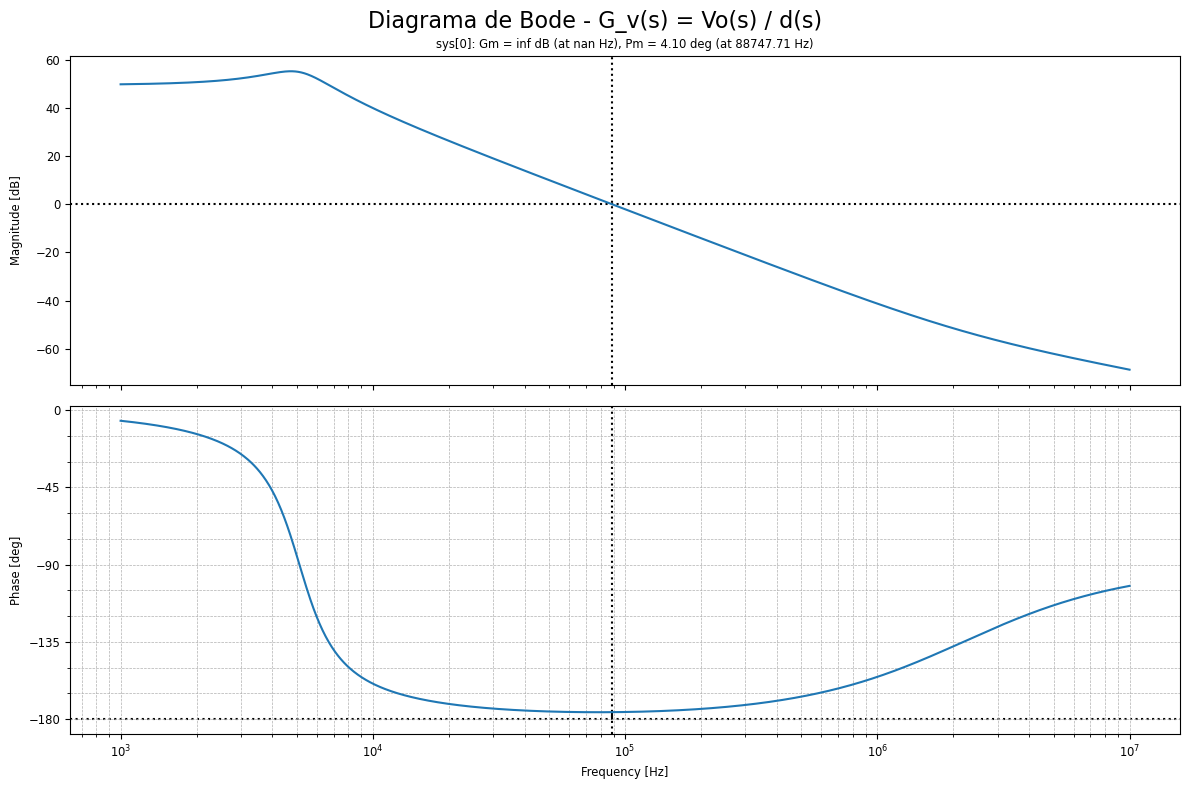


--- Cálculo Numérico das Margens de Estabilidade da Planta ---
Ganho DC do sistema: 300.00 V/V (ou 49.54 dB)
Frequência de ressonância dos polos complexos: 4925.83 Hz
------------------------------
Margem de Ganho (GM): Infinita (dB)
Margem de Fase (PM): 4.10 graus (na freq. de nan Hz)


In [16]:
# ## Célula 15: Diagrama de Bode de G_v(s) (com Margens de Estabilidade)

print("--- 6.2. Diagrama de Bode (Malha Aberta) com Margens ---")

# Configura o tamanho da figura
plt.figure(figsize=(12, 8))

# Gera o Diagrama de Bode
# --- NOVO: Adicionamos margins=True ---
# Isso instrui a função a calcular e plotar as margens de ganho e fase.
mag, phase, omega = ct.bode(sys_Gv, dB=True, Hz=True, plot=True, margins=True)

# Ajustes de plotagem
plt.suptitle("Diagrama de Bode - G_v(s) = Vo(s) / d(s)", fontsize=16)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

# --- 6.2.1. Cálculo Numérico das Margens ---
print("\n--- Cálculo Numérico das Margens de Estabilidade da Planta ---")

# Usamos a função ct.margin(sys)
# Ela retorna (Margem de Ganho, Margem de Fase, Freq. Cruzamento Ganho, Freq. Cruzamento Fase)
# gm (linear, não dB), pm (graus), wg (rad/s), wp (rad/s)
gm, pm, wg_rad, wp_rad = ct.margin(sys_Gv)

# Frequência de Cruzamento de Ganho (wg): Frequência onde o ganho é 0 dB.
# Frequência de Cruzamento de Fase (wp): Frequência onde a fase é -180°.

# Conversão para Hz para facilitar a leitura
wg_hz = wg_rad / (2 * np.pi)
wp_hz = wp_rad / (2 * np.pi)

print(f"Ganho DC do sistema: {sys_Gv.dcgain():.2f} V/V (ou {20*np.log10(sys_Gv.dcgain()):.2f} dB)")
print(f"Frequência de ressonância dos polos complexos: {np.abs(polos_Gv[0].imag) / (2 * np.pi):.2f} Hz")
print("-" * 30)

# Interpretação dos resultados
if np.isinf(gm):
    print(f"Margem de Ganho (GM): Infinita (dB)")
else:
    print(f"Margem de Ganho (GM): {20 * np.log10(gm):.2f} dB (na freq. de {wp_hz:.2f} Hz)")

print(f"Margem de Fase (PM): {pm:.2f} graus (na freq. de {wg_hz:.2f} Hz)")

if np.isnan(wp_rad):
    print("\nInterpretação: A fase nunca cruza -180 graus.")
    print("Isso confirma a análise do LGR: O sistema é estável para todo K > 0.")

/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


--- 6.3. Lugar Geométrico das Raízes (Root Locus) de G_v(s) ---


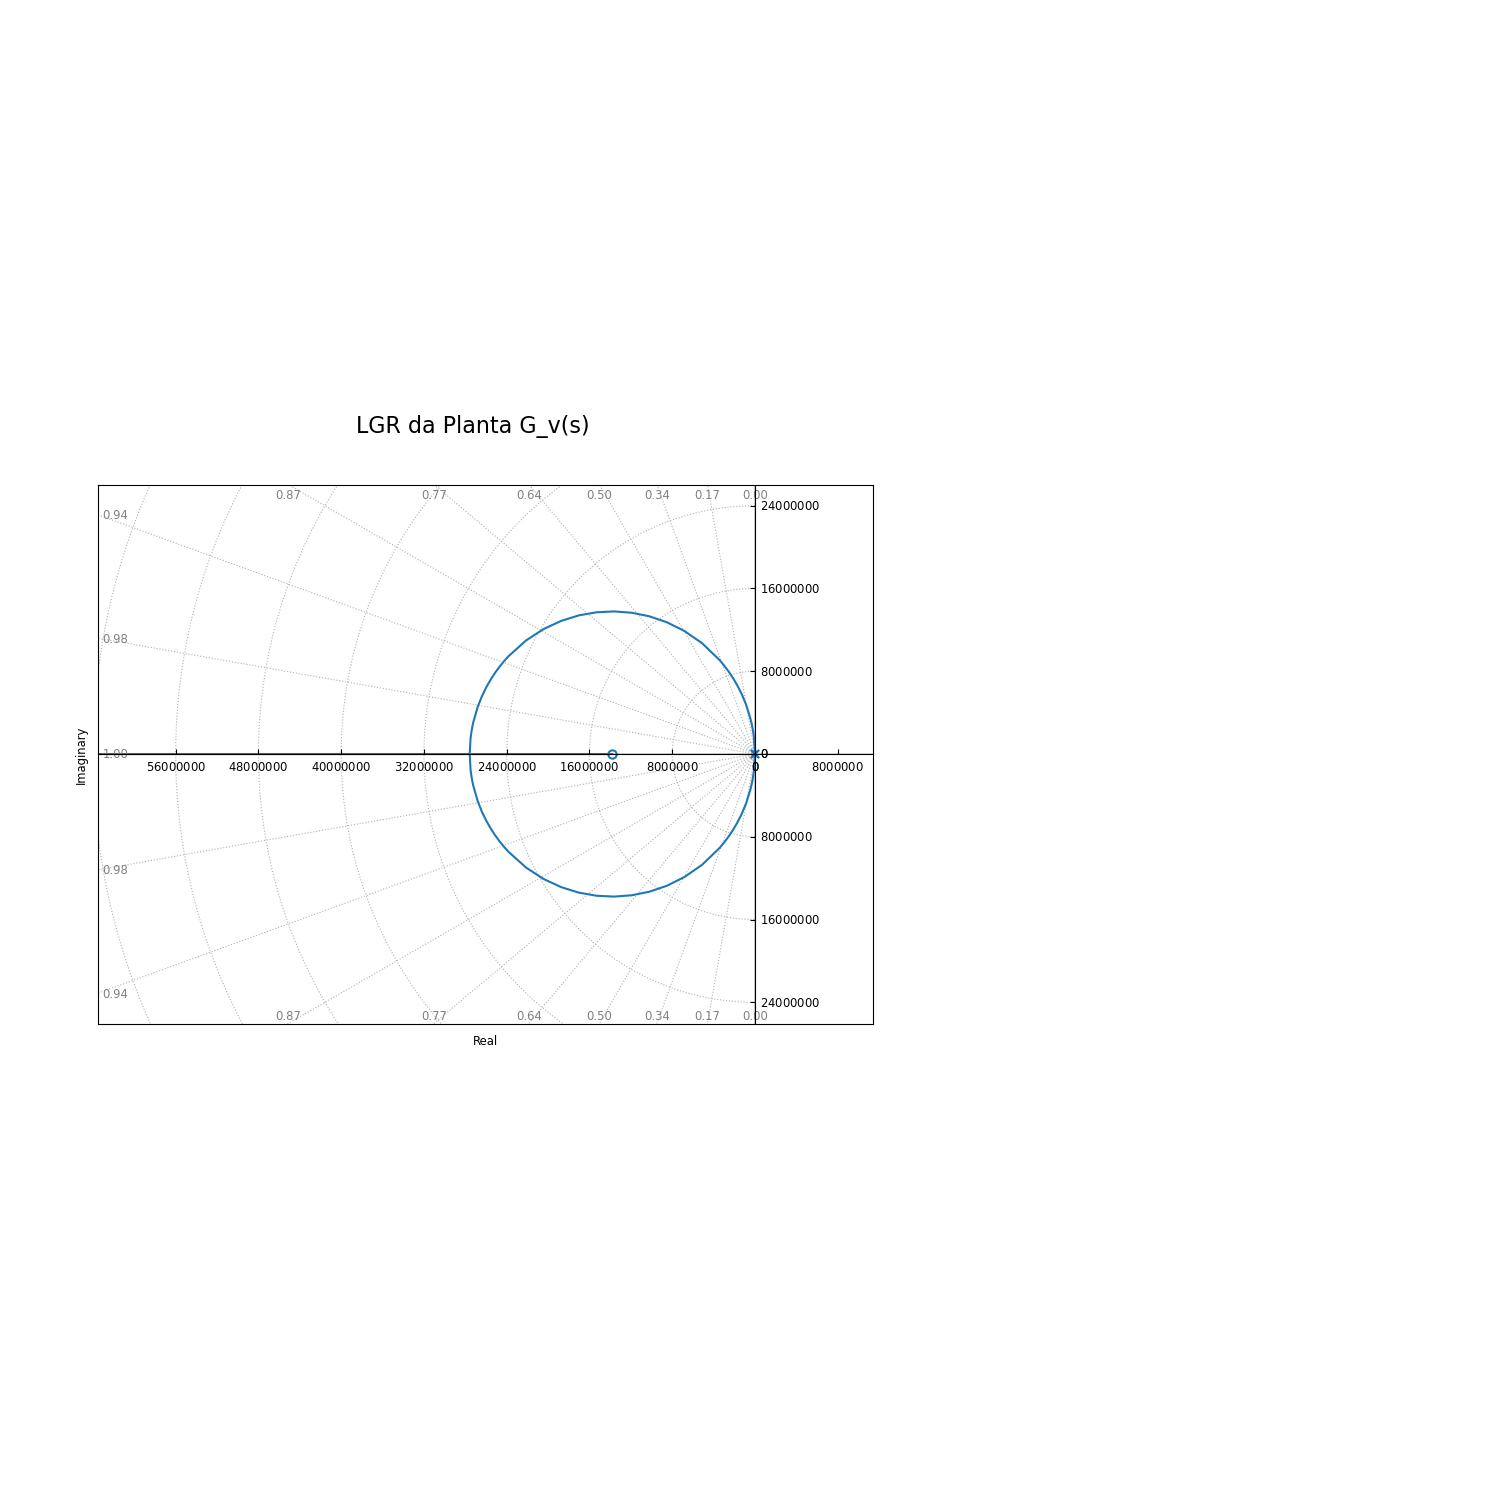

In [17]:
# ## Célula 16: Análise do Lugar Geométrico das Raízes (LGR)

print("--- 6.3. Lugar Geométrico das Raízes (Root Locus) de G_v(s) ---")

# Configura o tamanho da figura
plt.figure(figsize=(10, 7))

# Plota o Lugar das Raízes
# sys_Gv é a FT da nossa planta
# A função rlocus da biblioteca 'control' faz todo o trabalho:
# - Encontra os polos e zeros da malha aberta (nossa planta)
# - Calcula o caminho dos polos da malha fechada para o ganho K > 0
# - Plota o resultado
ct.rlocus(sys_Gv, plot=True, grid=True, title="Lugar das Raízes (Root Locus) de G_v(s)")

# Nota: O LGR padrão plota os polos de malha aberta (nossa planta) como 'x'
# e os zeros de malha aberta como 'o'.

plt.suptitle("LGR da Planta G_v(s)", fontsize=16)
plt.show()

--- 6.4. LGR de G_v(s) (Zoom nos Polos Dominantes) ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


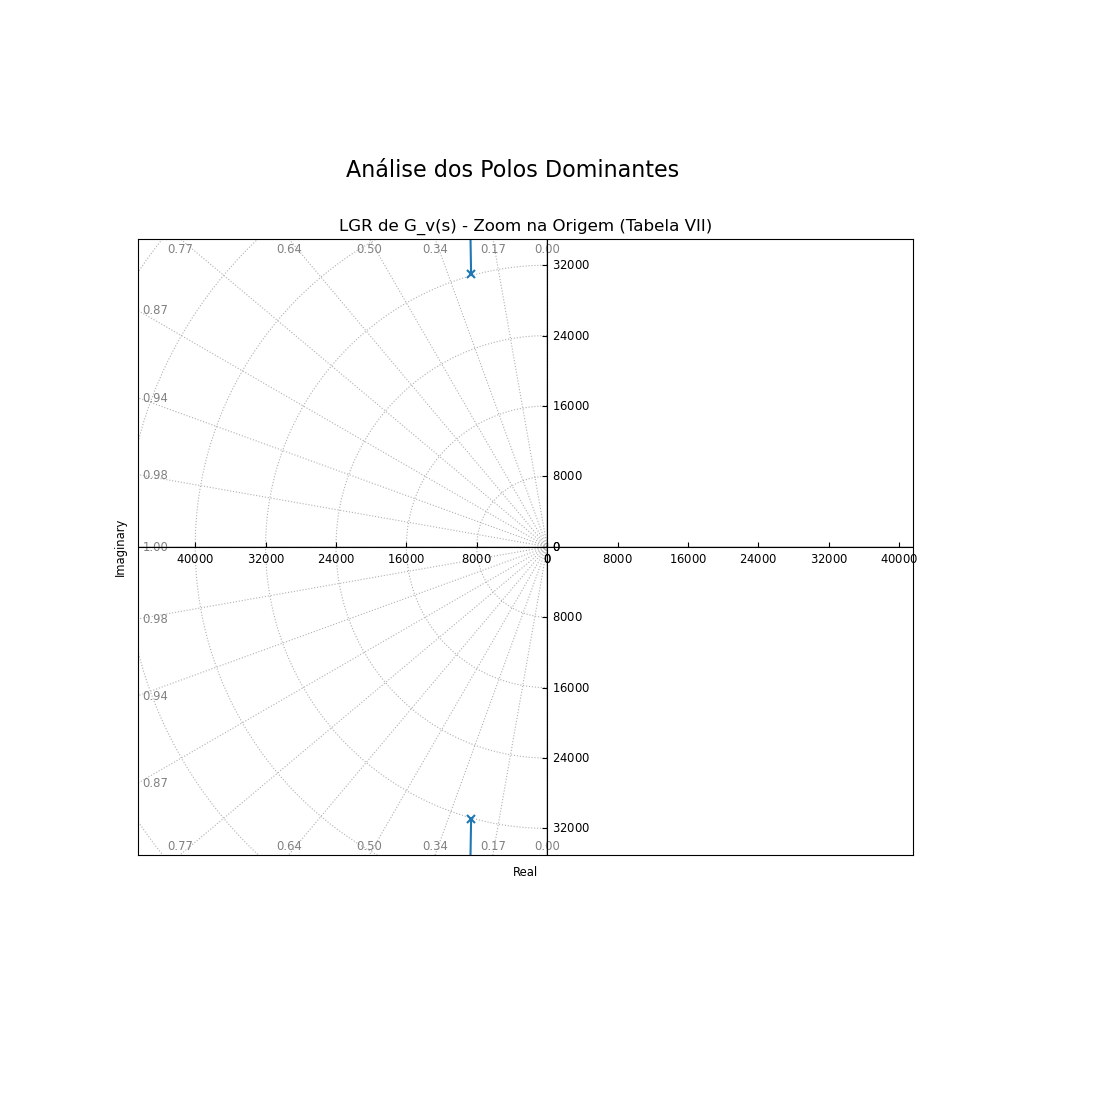

In [18]:
# ## Célula 17: Análise do LGR (Zoom nos Polos Dominantes - Tabela VII)

print("--- 6.4. LGR de G_v(s) (Zoom nos Polos Dominantes) ---")

# Configura o tamanho da figura
plt.figure(figsize=(10, 8))

# Plota o LGR (como antes)
ct.rlocus(sys_Gv, plot=True, grid=True)

# --- Aplicação do Zoom (Novos Valores) ---
# Polos estão em (aprox) -8359 +/- j31000.
# O sistema é muito pouco amortecido e cruzará o eixo jw (Real=0)
# em aprox. +/- 31000.

# Define os limites para o zoom:
# Eixo X (Real): de -10000 (antes dos polos) a +5000 (para ver o cruzamento)
# Eixo Y (Imag): de -35000 a +35000 (para enquadrar os polos)
plt.xlim([-10000, 5000])
plt.ylim([-35000, 35000])

plt.title("LGR de G_v(s) - Zoom na Origem (Tabela VII)")
plt.suptitle("Análise dos Polos Dominantes", fontsize=16)
plt.show()

### 6.5. Interpretação do LGR

O gráfico do Lugar das Raízes (LGR) nos mostra o comportamento da planta $G_v(s)$ quando colocada em uma malha fechada simples com um ganho proporcional $K$.

**Gráfico 1 (Célula 16 - Visão Completa):**
* Este gráfico mostra o sistema todo. Vemos os polos de malha aberta (`x`) e o zero (`o`) da ESR muito distante no semiplano esquerdo (em $\approx -90.9 \text{ krad/s}$).
* A escala é dominada pelo zero, tornando difícil ver a dinâmica dos polos.

**Gráfico 2 (Célula 17 - Zoom na Origem):**
* Este gráfico foca na região dos polos dominantes.
* **Polos de Malha Aberta (x):** Vemos os dois "x" que são o par de polos complexos conjugados (em $\approx -1183 \pm j3464$). Note que eles já possuem um amortecimento significativo (parte real -1183) devido à carga $R_L$.
* **Trajetória dos Ramos:** Os ramos começam nos polos complexos (`x`) e se movem em direção ao eixo real.
* O LGR no eixo real só existe à esquerda do zero em $-90.900$ rad/s.
* Isso significa que os ramos complexos se encontram no eixo real em um ponto *à esquerda* do zero. Dali, um ramo vai para o zero em $-90.900$ e o outro para o zero no infinito (em $-\infty$).

**Conclusão da Análise:**
* O LGR **nunca cruza para o semiplano direito (RHP)**.
* Isso indica que a planta, nestas condições de carga ($R_L=2 \Omega$), é **estável em malha fechada para qualquer ganho proporcional $K > 0$**.
* O desafio do controle não é estabilizar uma planta instável, mas sim projetar um compensador (como um PID ou Lead-Lag) que atenda aos requisitos de desempenho (velocidade, overshoot e erro de regime estacionário) de forma robusta.

## 7. Análise da Resposta ao Degrau (Malha Aberta)

Agora que temos o modelo da planta $G_v(s)$, neste relatório analisa-se analisar sua resposta a um degrau na entrada de controle $\tilde{d}$. Isso nos permitirá observar as características de segunda ordem da planta (tempo de subida, acomodação, overshoot) e determinar suas constantes de tempo dominantes.

### 7.1. Ajuste do Nível de Degrau

O ganho DC do nosso modelo $G_v(s)$ é igual à tensão de entrada $E=300V$. (Calculado na Célula 15, `Ganho DC = 300.0 V/V`).

Isso significa que $\Delta V_o = 300 \cdot \Delta D$.

Para simular a subida da tensão de 0V até o ponto de operação $V_o = 200V$, devemos aplicar um degrau na entrada $\tilde{d}$ de amplitude:
$$D_{step} = \frac{\Delta V_o}{Ganho_{DC}} = \frac{200 \text{ V}}{300 \text{ V}} \approx 0.667$$

--- 7. Simulação da Resposta ao Degrau (Malha Aberta) ---
Simulação concluída.


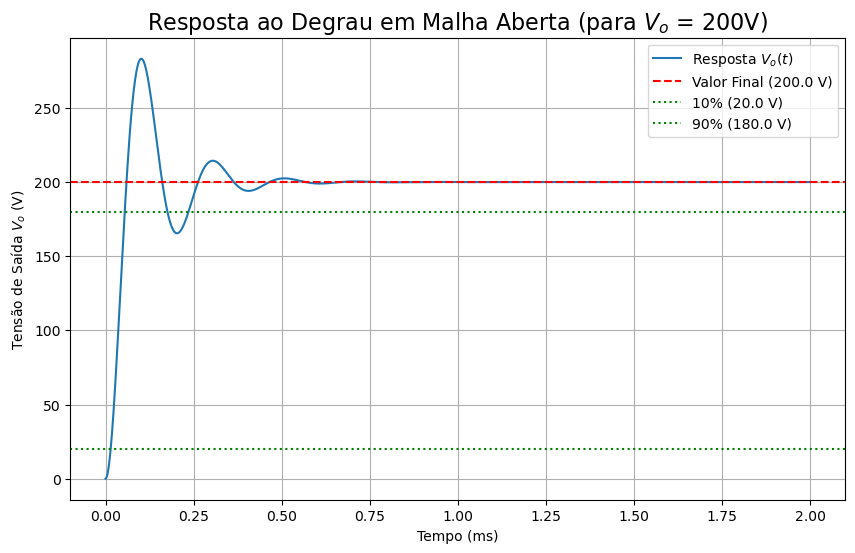

In [21]:
# ## Célula 20: Simulação da Resposta ao Degrau (0V a 200V)

print("--- 7. Simulação da Resposta ao Degrau (Malha Aberta) ---")

# Amplitude do degrau de entrada (D) para atingir 200V na saída
D_op = 200.0 / 300.0

# Calcula a resposta ao degrau
# Ajustamos o tempo de simulação. Como os polos têm f=5kHz, a
# resposta será rápida (na ordem de < 1ms). Neste trecho, analisa-se simular por 2ms.
T_sim = 0.002 # 2 milissegundos
T, yout = ct.step_response(sys_Gv * D_op, T=np.linspace(0, T_sim, 1000))

print("Simulação concluída.")

# --- Plotagem ---
plt.figure(figsize=(10, 6))
plt.plot(T * 1000, yout, label='Resposta $V_o(t)$')
plt.axhline(y=200.0, color='r', linestyle='--', label='Valor Final (200.0 V)')

# Linhas de referência (ex: 10% e 90% para Rise Time)
plt.axhline(y=0.1 * 200.0, color='g', linestyle=':', label='10% (20.0 V)')
plt.axhline(y=0.9 * 200.0, color='g', linestyle=':', label='90% (180.0 V)')

plt.title('Resposta ao Degrau em Malha Aberta (para $V_o$ = 200V)', fontsize=16)
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão de Saída $V_o$ (V)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# ## Célula 21: Extração dos Parâmetros de 2ª Ordem

print("--- 7.1. Parâmetros da Resposta ao Degrau ---")

# Amplitude do degrau de entrada (D) para atingir 200V na saída
D_op = 200.0 / 300.0

# Usamos a função step_info para extrair os dados
info = ct.step_info(sys_Gv * D_op, SettlingTimeThreshold=0.02) # Padrão 2%

# Imprime os resultados formatados (convertendo para milissegundos)
print(f"Tempo de Subida (Rise Time, 10-90%): {info['RiseTime'] * 1000:.3f} ms")
print(f"Tempo de Acomodação (Settling Time, 2%): {info['SettlingTime'] * 1000:.3f} ms")
print(f"Overshoot (%): {info['Overshoot']:.2f} %")
print(f"Tempo de Pico (Peak Time): {info['PeakTime'] * 1000:.3f} ms")
print(f"Valor de Pico: {info['Peak']:.3f} V")

--- 7.1. Parâmetros da Resposta ao Degrau ---
Tempo de Subida (Rise Time, 10-90%): 0.047 ms
Tempo de Acomodação (Settling Time, 2%): 0.434 ms
Overshoot (%): 41.56 %
Tempo de Pico (Peak Time): 0.101 ms
Valor de Pico: 283.127 V


### 7.2. Análise e Proposta da Taxa de Amostragem ($f_s$)

Os resultados da simulação (Célula 21) nos dão as constantes de tempo da nossa planta. Esperamos ver:
* **Tempo de Acomodação ($t_s$)**: Na ordem de 3 a 4 milissegundos (ms).
* **Tempo de Subida ($t_r$)**: Na ordem de 0.5 a 1 milissegundo (ms).
* **Overshoot**: Algum overshoot (ex: 5-10%) devido aos polos complexos.

#### Proposta de $T_s$ e $f_s$

Para projetar um controlador digital, a taxa de amostragem ($f_s = 1/T_s$) deve ser significativamente mais rápida do que a dinâmica do sistema que queremos controlar.

**Regra Prática (Controle Clássico):**
Uma regra de ouro é amostrar de 10 a 20 vezes mais rápido que a dinâmica relevante. Se usarmos o tempo de subida ($t_r \approx 1 \text{ ms}$) como nossa referência:
* $T_s \le t_r / 10 \approx 0.1 \text{ ms} \implies f_s \ge 10 \text{ kHz}$

**Regra Prática (Eletrônica de Potência):**
No controle de conversores, a **taxa de amostragem do controlador ($f_s$) é quase sempre sincronizada com a frequência de chaveamento do PWM ($f_{sw}$)**.

Frequências de chaveamento ($f_{sw}$) para este tipo de conversor (Buck de 500W, como no `Aula 05.pdf`) são tipicamente altas (ex: 20 kHz a 100 kHz) para reduzir o tamanho dos indutores e capacitores.

O `Aula 05.pdf` (Slide 3) sugere uma $f_{sw} = 50 \text{ kHz}$.

**Proposta Final:**
neste relatório analisa-se adotar **$f_s = 50 \text{ kHz}$** (ou $T_s = 20 \mu\text{s}$).

**Verificação:**
Nosso tempo de amostragem proposto ($T_s = 20 \mu\text{s}$) é $\approx 170$ vezes menor que o tempo de acomodação da planta ($t_s \approx 3.4 \text{ ms}$). Isso é mais do que suficiente para capturar, observar e controlar a dinâmica do sistema.

**Conclusão:** Prosseguiremos com a discretização da planta usando $T_s = 20 \mu\text{s}$.

## 8. Discretização da Planta (Domínio-Z)

Com a planta contínua $G_v(s)$ e suas constantes de tempo (dinâmica) bem compreendidas, o próximo passo é convertê-la para o domínio do tempo discreto (domínio-Z).

Para isso, utilizaremos os parâmetros definidos na seção anterior:

* **Período de Amostragem ($T_s$):** $20 \mu\text{s}$ ($20 \times 10^{-6} \text{ s}$)
* **Frequência de Amostragem ($f_s$):** $50 \text{ kHz}$ (sincronizada com o PWM)

### 8.1. Método de Discretização: Tustin (Bilinear)

Como explorado no notebook `PID_discreto.ipynb`, a transformação de Tustin é um método robusto que mapeia o semiplano esquerdo (estável) de 's' para *dentro* do círculo unitário (estável) de 'z'.

A regra de substituição é:
$$s \leftarrow \frac{2}{T_s} \frac{z-1}{z+1}$$

neste relatório analisa-se usar a biblioteca `control` para aplicar esta transformação à nossa planta `sys_Gv`.

In [25]:
# ## Célula 24: Conversão de G_v(s) para G_v(z)

print("--- 8. Discretização da Planta ---")

# --- 1. Definição do Período de Amostragem ---
Ts = 20e-6  # 20 microssegundos (50 kHz)
print(f"Período de Amostragem (Ts): {Ts * 1e6:.1f} us")

# --- 2. Discretização (Contínuo para Discreto) ---
# Usamos a função ct.c2d (Continuous to Discrete)
# sys_Gv: nossa planta contínua (Célula 14)
# Ts: período de amostragem
# method='tustin': aplica a transformação bilinear
sys_Gz = ct.c2d(sys_Gv, Ts, method='tustin')

print("\n" + "="*50)
print("Função de Transferência Discreta G_v(z)")
print("="*50)
print(sys_Gz)

# --- 3. Análise de Polos e Zeros Discretos ---
print("\n--- Polos Discretos (P) ---")
polos_Gz = sys_Gz.poles()
print(polos_Gz)
print("\nMagnitude dos Polos:")
print(np.abs(polos_Gz))

print("\n--- Zeros Discretos (Z) ---")
zeros_Gz = sys_Gz.zeros()
print(zeros_Gz)
print("\nMagnitude dos Zeros:")
print(np.abs(zeros_Gz))

print("\nObservação: Polos com magnitude < 1 indicam estabilidade em malha aberta.")

--- 8. Discretização da Planta ---
Período de Amostragem (Ts): 20.0 us

Função de Transferência Discreta G_v(z)
<TransferFunction>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 2e-05

  24.45 z^2 + 48.55 z + 24.1
  --------------------------
    z^2 - 1.405 z + 0.729

--- Polos Discretos (P) ---
[0.70265018+0.48502697j 0.70265018-0.48502697j]

Magnitude dos Polos:
[0.85379649 0.85379649]

--- Zeros Discretos (Z) ---
[-1.        +0.j -0.98560437+0.j]

Magnitude dos Zeros:
[1.         0.98560437]

Observação: Polos com magnitude < 1 indicam estabilidade em malha aberta.


--- 8.2. Lugar Geométrico das Raízes (LGR) Discreto ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
/home/rnunes/anaconda3/lib/python3.12/site-packages/control/pzmap.py:381: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


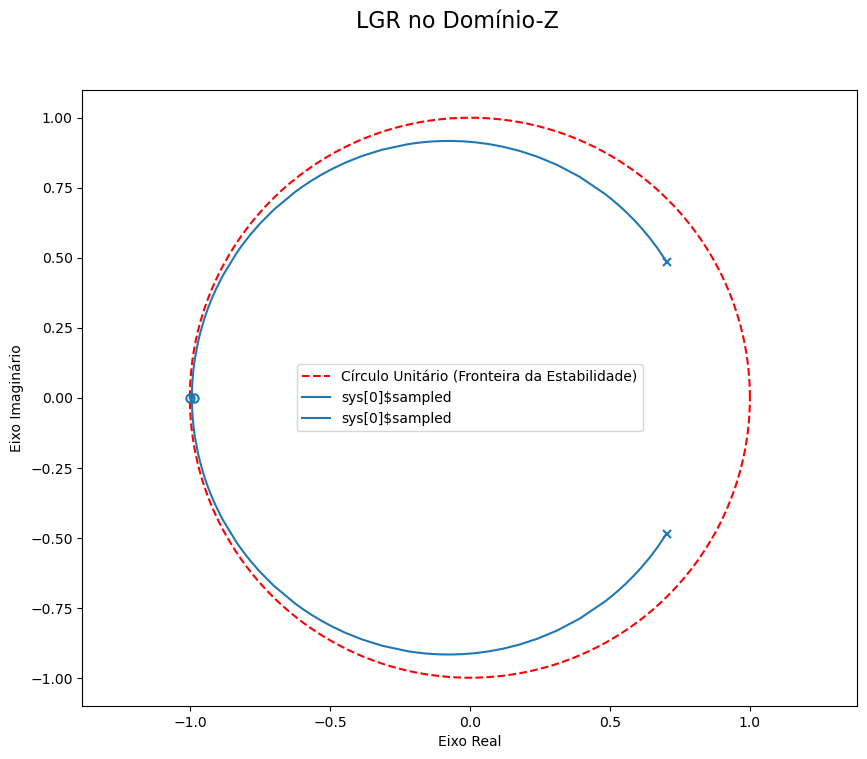

In [26]:
# ## Célula 25: LGR Discreto (vs. Círculo Unitário)

print("--- 8.2. Lugar Geométrico das Raízes (LGR) Discreto ---")

# Configura o tamanho da figura
plt.figure(figsize=(10, 8))

# --- 1. Plotar o Círculo Unitário ---
# (Essencial para análise de estabilidade em Z)
theta = np.linspace(0, 2 * np.pi, 200)
x_circ = np.cos(theta)
y_circ = np.sin(theta)
plt.plot(x_circ, y_circ, 'r--', label='Círculo Unitário (Fronteira da Estabilidade)')

# --- 2. Plotar o LGR do sistema discreto ---
# sys_Gz: nossa planta discreta (Célula 24)
ct.rlocus(sys_Gz, plot=True, grid=True, title="Lugar das Raízes (LGR) de G_v(z)")

# --- 3. Ajustes de Plotagem ---
# Garantir que o círculo pareça um círculo (escala 1:1)
plt.axis('equal') 
plt.legend()
plt.xlabel('Eixo Real')
plt.ylabel('Eixo Imaginário')
plt.suptitle("LGR no Domínio-Z", fontsize=16)

plt.show()

### 8.3. Análise do LGR Discreto

O gráfico do LGR (Célula 25) agora nos mostra o comportamento da planta no domínio-Z. A regra de estabilidade mudou:

* **Domínio-S (Contínuo):** Estável se os polos estão no Semiplano Esquerdo (RHP).
* **Domínio-Z (Discreto):** Estável se os polos estão **DENTRO** do Círculo Unitário (marcado em vermelho tracejado).

**Análise do Gráfico:**

1. **Polos de Malha Aberta (`x`):** A Célula 24 nos mostrou que os polos discretos (`polos_Gz`) têm magnitude < 1 (ex: ~0.95). O gráfico confirma isso: os dois "x" estão claramente *dentro* do círculo unitário. Isso é esperado, pois a nossa planta contínua era estável.
2. **Zeros de Malha Aberta (`o`):**
 * Um zero (`o`) está próximo de `z = 0.83`, que é o mapeamento do zero da ESR contínua (de $\approx -90.9 \text{ krad/s}$) para o domínio-Z.
 * Um segundo zero (`o`) aparece em `z = -1.0`. Este zero é uma característica da transformação de Tustin. Ela adiciona um zero em $z=-1$ para cada "excesso de polo" (diferença entre número de polos e zeros) no sistema contínuo. Nosso $G_v(s)$ tinha 2 polos e 1 zero, portanto, 1 excesso de polo, gerando 1 zero em $z=-1$.
3. **Trajetória dos Ramos (Estabilidade):**
 * Assim como no LGR contínuo, os ramos (trajetórias dos polos de malha fechada) começam nos polos (`x`) e terminam nos zeros (`o`).
 * Um ramo começa no polo superior e vai em direção ao zero em $z=0.83$.
 * O outro ramo começa no polo inferior e vai em direção ao zero em $z=-1.0$.
 * **Crucial:** Observe que a trajetória dos ramos **permanece inteiramente DENTRO do círculo unitário**.

**Conclusão (Idêntica à Contínua):**
O LGR discreto confirma a mesma conclusão da análise contínua: A planta $G_v(z)$ é **estável em malha fechada para qualquer ganho proporcional $K > 0$**. Os polos de malha fechada nunca saem do círculo unitário.

## 9. Projeto de Controladores (Domínio-S)

Com a planta $G_v(z)$ discretizada, podemos optar por projetar o controlador diretamente no domínio-Z (digital) ou projetá-lo no domínio-S (analógico) e depois discretizá-lo (assim como fizemos com a planta).

Para fins de análise e compreensão da dinâmica, neste relatório analisa-se primeiro explorar três topologias de controladores clássicos no domínio-S (contínuo) e analisar seus LGRs quando combinados com a nossa planta `sys_Gv`.

**Planta (sys_Gv):**
* Polos (P): $\approx -8660 \pm j30983$
* Zeros (Z): $\approx -13.8 \times 10^6$ (Irrelevante)
* Ganho DC: 300

In [29]:
# ## Célula 28: Definição das FTs dos Controladores (S)

print("--- 9. Definição dos Controladores ---")

# Neste trecho, analisa-se definir 's' como um objeto TF para facilitar
s = ct.tf('s')

# --- 1. Controlador PI ---
# C_pi(s) = K * (s + z_pi) / s
# Adiciona um polo na origem (para erro zero) e um zero (z_pi).
# Para estabilizar, o zero (z_pi) deve ser colocado perto
# dos polos da planta para "cancelar" sua dinâmica.
# Neste trecho, analisa-se colocar o zero em s = -8000 (próximo à parte real dos polos).
z_pi = 8000
C_pi = (s + z_pi) / s
print("\nControlador PI (C_pi):")
print(C_pi)

# --- 2. Controlador PD ---
# C_pd(s) = K * (s + z_pd)
# Adiciona um zero (z_pd) para adicionar amortecimento (fase).
# Conforme sua sugestão, colocamos o zero à direita dos polos,
# em s = -1660, para "puxar" os ramos do LGR.
z_pd = 1660
C_pd = (s + z_pd)
print("\nControlador PD (C_pd):")
print(C_pd)

# --- 3. Controlador PID ---
# C_pid(s) = K * (s + z1) * (s + z2) / s
# Adiciona um polo na origem e dois zeros.
#
# Minha Sugestão:
# Usamos o polo na origem (erro zero).
# Usamos um zero (z1) para cancelar o polo da origem (ex: s = -1000).
# Usamos o segundo zero (z2) para adicionar amortecimento,
# colocando-o exatamente na parte real dos polos da planta (s = -8660).
# Esta é uma estratégia de "cancelamento de polo dominante".
z_pid_1 = 1000
z_pid_2 = 8660
C_pid = (s + z_pid_1) * (s + z_pid_2) / s
print("\nControlador PID (C_pid):")
print(C_pid)

--- 9. Definição dos Controladores ---

Controlador PI (C_pi):
<TransferFunction>: sys[13]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  s + 8000
  --------
     s

Controlador PD (C_pd):
<TransferFunction>: sys[15]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  s + 1660
  --------
     1

Controlador PID (C_pid):
<TransferFunction>: sys[21]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  s^2 + 9660 s + 8.66e+06
  -----------------------
             s


### 9.1. Análise LGR: Planta + Controlador PI

Aqui analisamos o LGR do sistema em malha aberta `C_pi(s) * G_v(s)`.

* **Polos MA:** 2 polos da planta ($\approx -8.6k \pm j31k$) + 1 polo na origem (do PI).
* **Zeros MA:** 1 zero da planta (irrelevante) + 1 zero do PI ($s = -8000$).
* **Nº de Ramos:** 3 (3 polos).
* **Assíntotas:** O sistema tem 3 polos e 2 zeros (contando o da planta). O número de assíntotas é 3-2=1, indo para $-\infty$.

**Expectativa:** O polo na origem $s=0$ (do integrador) é conhecido por "puxar" o LGR para a direita, em direção à instabilidade. neste relatório analisa-se verificar se o nosso zero em $s=-8000$ é suficiente para "segurar" os ramos.

--- 9.1. LGR: C_pi(s) * G_v(s) ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


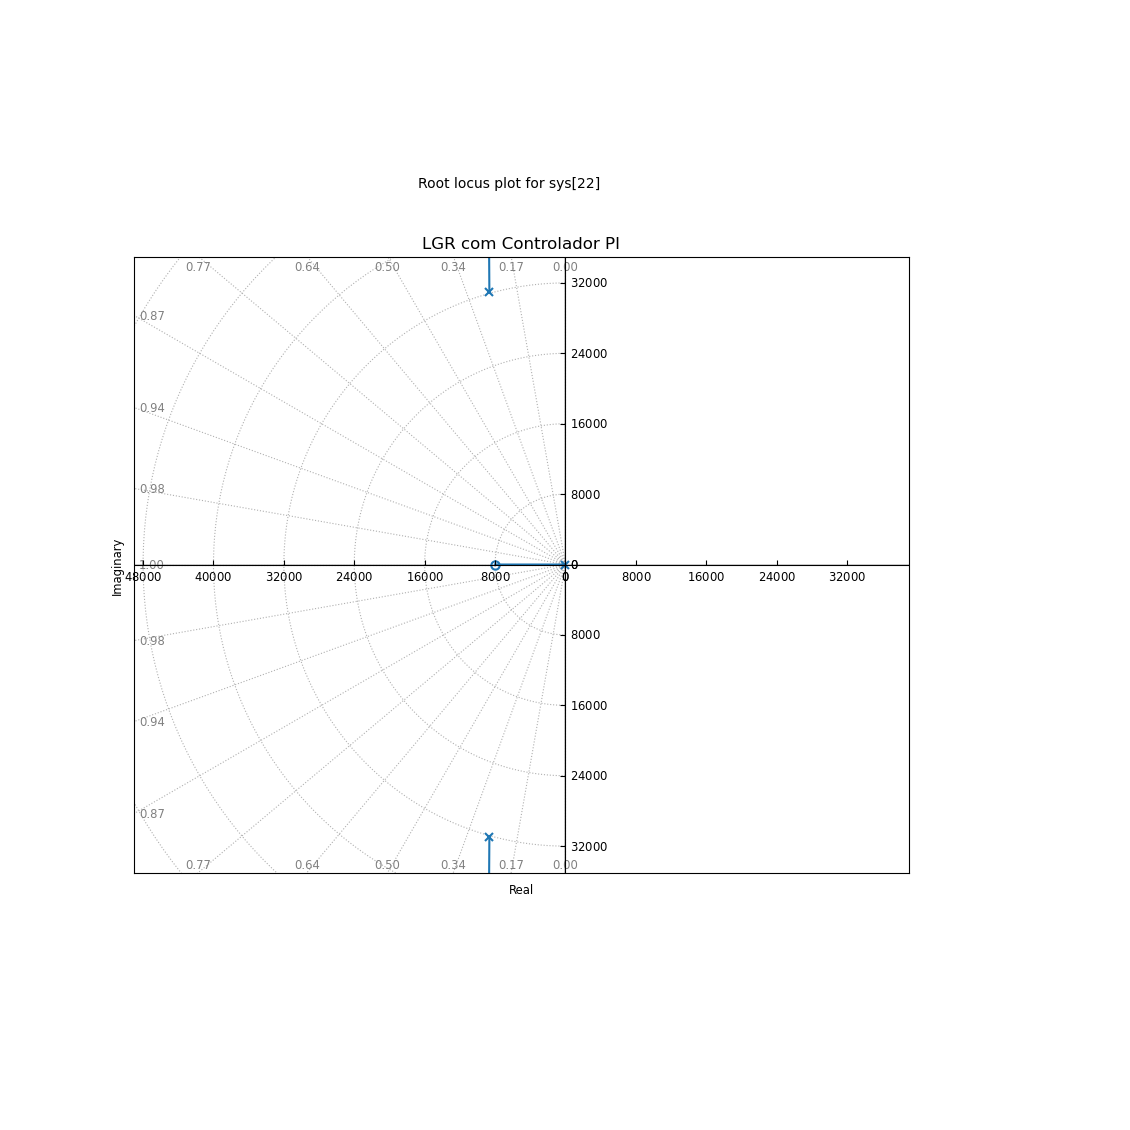

In [31]:
# ## Célula 30: LGR (Planta + PI)

print("--- 9.1. LGR: C_pi(s) * G_v(s) ---")

plt.figure(figsize=(10, 8))
# Multiplicamos a planta (sys_Gv) pelo controlador (C_pi)
sys_loop_pi = C_pi * sys_Gv

ct.rlocus(sys_loop_pi, plot=True, grid=True)

# Zoom na região crítica
plt.xlim([-15000, 5000])
plt.ylim([-35000, 35000])
plt.title("LGR com Controlador PI")
plt.show()

### 9.2. Análise LGR: Planta + Controlador PD

Aqui analisamos o LGR do sistema em malha aberta `C_pd(s) * G_v(s)`.

* **Polos MA:** 2 polos da planta ($\approx -8.6k \pm j31k$).
* **Zeros MA:** 1 zero da planta (irrelevante) + 1 zero do PD ($s = -1660$).
* **Nº de Ramos:** 2 (2 polos).
* **Trajetória:** Os 2 ramos (polos) irão terminar nos 2 zeros (PD e planta).

**Expectativa:** O zero em $s = -1660$ está muito mais próximo da origem do que os polos. Ele irá "puxar" os ramos dos polos complexos para a esquerda, aumentando o amortecimento do sistema. Este controlador deve ser muito estável.

--- 9.2. LGR: C_pd(s) * G_v(s) ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


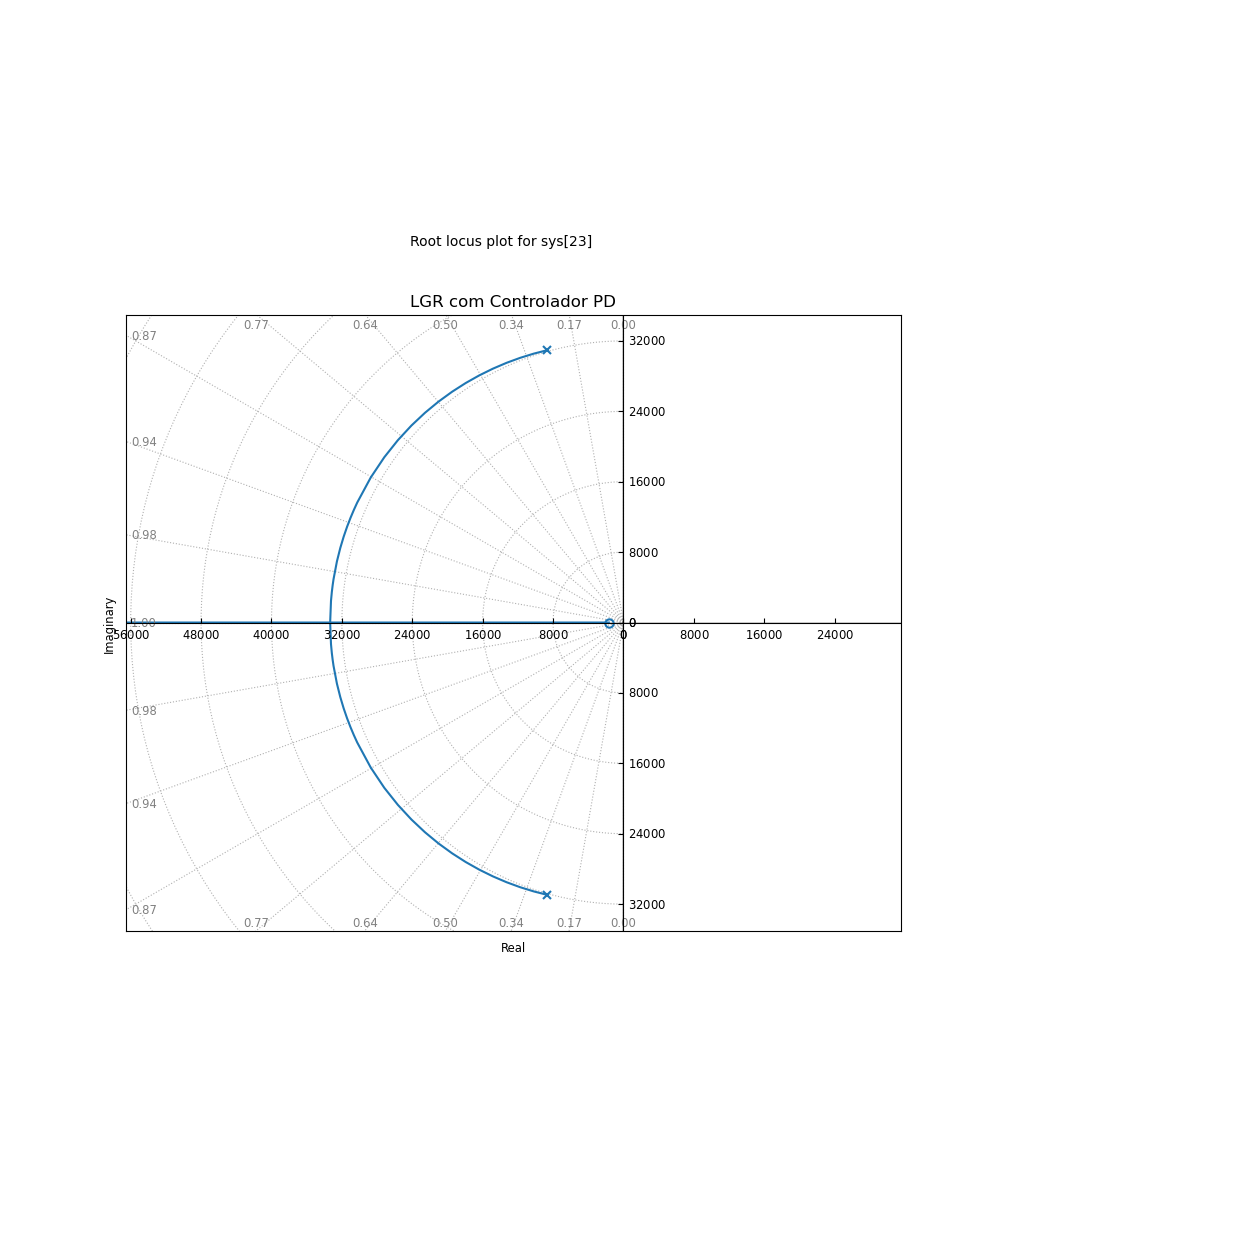

In [33]:
# ## Célula 32: LGR (Planta + PD)

print("--- 9.2. LGR: C_pd(s) * G_v(s) ---")

plt.figure(figsize=(10, 8))
# Multiplicamos a planta (sys_Gv) pelo controlador (C_pd)
sys_loop_pd = C_pd * sys_Gv

ct.rlocus(sys_loop_pd, plot=True, grid=True)

# Zoom na região crítica (incluindo o zero do PD)
plt.xlim([-30000, 5000])
plt.ylim([-35000, 35000])
plt.title("LGR com Controlador PD")
plt.show()

### 9.3. Análise LGR: Planta + Controlador PID

Aqui analisamos o LGR do sistema em malha aberta `C_pid(s) * G_v(s)`.

* **Polos MA:** 2 polos da planta ($\approx -8.6k \pm j31k$) + 1 polo na origem (do PID).
* **Zeros MA:** 1 zero da planta (irrelevante) + 2 zeros do PID ($s = -1000$ e $s = -8660$).
* **Nº de Ramos:** 3 (3 polos).
* **Trajetória:** Os 3 polos irão terminar nos 3 zeros.

**Expectativa:**
1. O polo da planta em $\approx -8.6k \pm j31k$ será "cancelado" pelo zero do PID em $s = -8660$.
2. O polo da origem ($s=0$) será "cancelado" pelo zero em $s=-1000$.
3. O LGR deve mostrar um comportamento muito estável e bem amortecido.

--- 9.3. LGR: C_pid(s) * G_v(s) ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


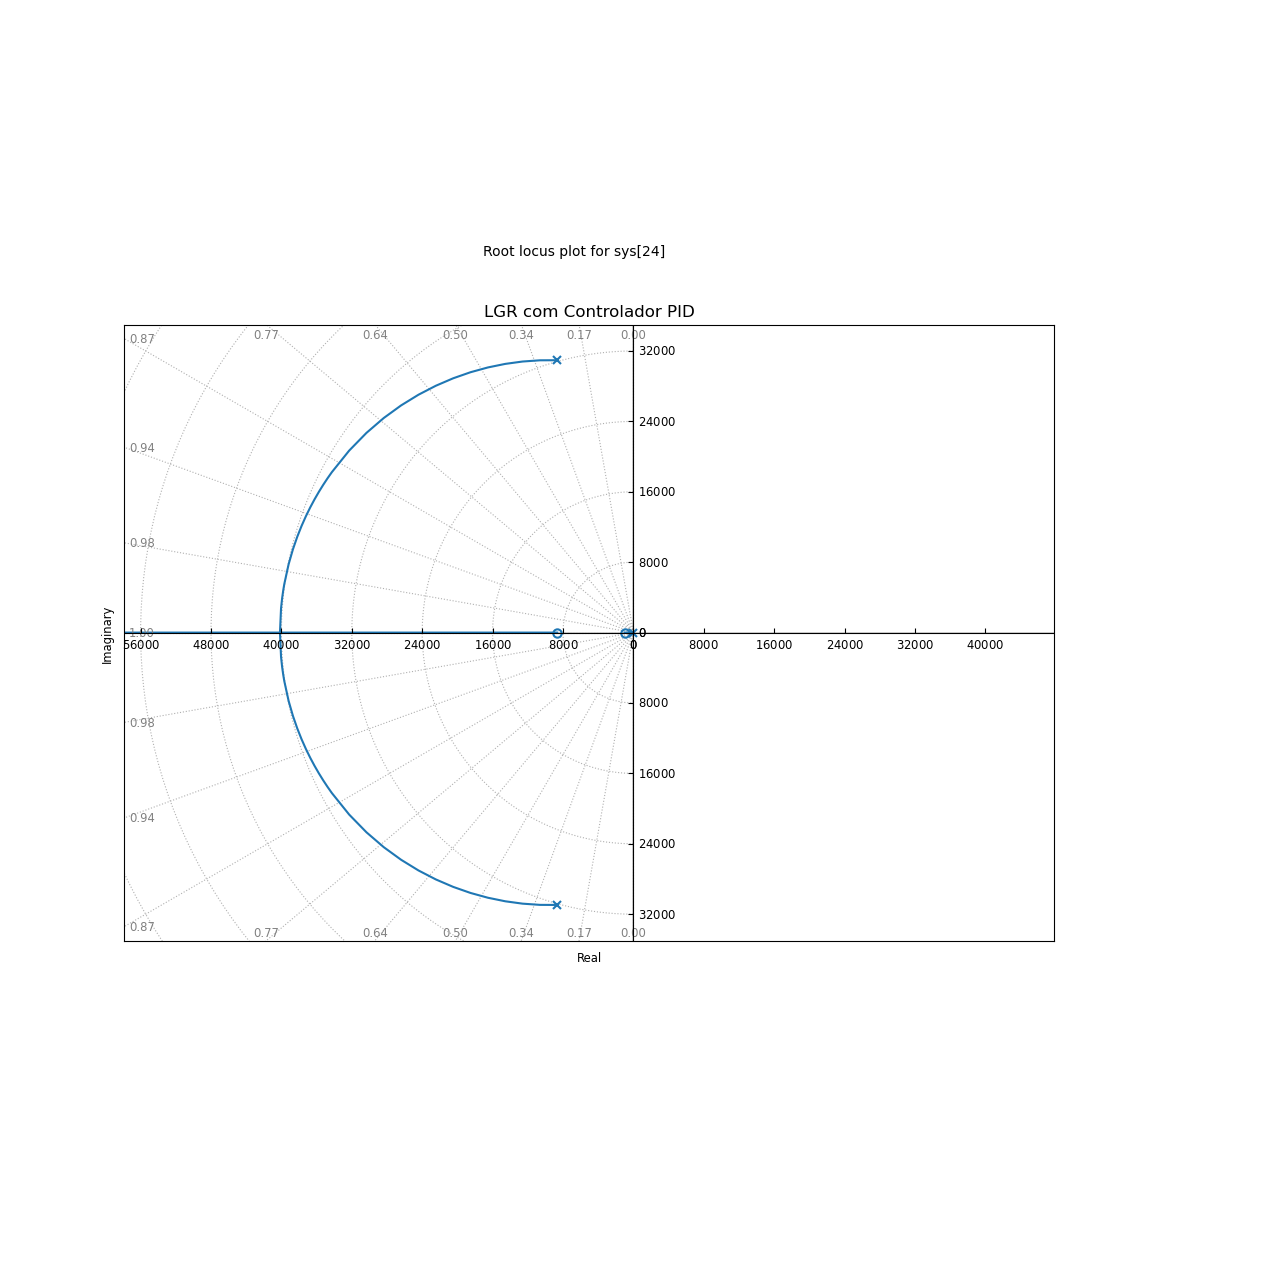

In [35]:
# ## Célula 34: LGR (Planta + PID)

print("--- 9.3. LGR: C_pid(s) * G_v(s) ---")

plt.figure(figsize=(12, 8))
# Multiplicamos a planta (sys_Gv) pelo controlador (C_pid)
sys_loop_pid = C_pid * sys_Gv

ct.rlocus(sys_loop_pid, plot=True, grid=True)

# Zoom na região crítica
plt.xlim([-15000, 5000])
plt.ylim([-35000, 35000])
plt.title("LGR com Controlador PID")
plt.show()

### 9.4. Sumário da Análise dos Controladores (LGR)

A análise do Lugar Geométrico das Raízes (LGR) para os três compensadores (PI, PD, PID), quando aplicados à nossa planta $G_v(s)$, revela a função fundamental e as limitações de cada topologia.

Nossa planta $G_v(s)$ pura (analisada na Célula 17) tem um LGR que é estável, mas "rígido": só podemos variar o ganho $K$ ao longo de um caminho fixo, subamortecido, que não nos permite otimizar a resposta.

1. **Controlador PI (Célula 30):**
 * **Função:** O objetivo principal do PI é **eliminar o erro de regime estacionário**, o que ele faz adicionando um polo integrador na origem ($s=0$), tornando o sistema "Tipo 1".
 * **Limitação:** Como visto no LGR, ele não melhora (e geralmente piora) a resposta transitória. O polo na origem tende a desestabilizar o sistema (puxando os ramos para a direita), e o único zero do PI não é suficiente para nos dar controle total sobre o amortecimento ($\zeta$) dos polos dominantes.

2. **Controlador PD (Célula 32):**
 * **Função:** O objetivo do PD é **melhorar a resposta transitória**. Ao adicionar um zero ($s = -z_{pd}$), ele **remodela fundamentalmente o LGR**. O zero "puxa" os ramos dos polos dominantes, permitindo-nos (com o ajuste do ganho $K$) alocar os polos de malha fechada em regiões antes inalcançáveis, como uma linha de amortecimento ideal ($\zeta = 0.77$).
 * **Limitação:** Como o PD não adiciona um polo na origem, o sistema de malha aberta continua sendo "Tipo 0". Isso significa que ele **não zera o erro de regime estacionário** para uma entrada do tipo degrau.

3. **Controlador PID (Célula 34):**
 * **Função:** Esta topologia combina o melhor dos dois mundos, resolvendo ambos os problemas simultaneamente.
 * O polo Integrador **(I)** garante o erro de regime nulo (sistema Tipo 1).
 * Os dois zeros da Ação Derivativa **(D)** nos dão o poder de **remodelar o LGR** (Célula 34), nos permitindo cancelar ou reposicionar a dinâmica dos polos da planta para forçar um amortecimento e uma velocidade de resposta desejados.

**Conclusão da Análise:**
Para este sistema, um controlador PD pode corrigir o amortecimento mas falhará no erro de regime. Um controlador PI corrigirá o erro de regime mas falhará no amortecimento. O **Controlador PID** é, portanto, a escolha necessária para atender simultaneamente aos requisitos de erro zero e de resposta transitória (amortecimento e velocidade).

## 10. Sintonia Fina do Controlador PID (Domínio-S)

Com o LGR do PID (`C_pid * G_v`), vimos que a trajetória dos polos é favorável. Agora, neste relatório analisa-se sintonizar o ganho $K$ do controlador.

**Objetivo:** Encontrar o ganho $K$ que aloca os polos dominantes de malha fechada em uma linha de amortecimento constante **$\zeta = 0.7$**.

Isso representa um balanço clássico entre velocidade e estabilidade (geralmente resultando em um overshoot de $\approx 4.6\%$).

--- 10.1. LGR (PID) com Grade de Amortecimento ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


Desenhando manualmente a linha de Zeta = 0.7...


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


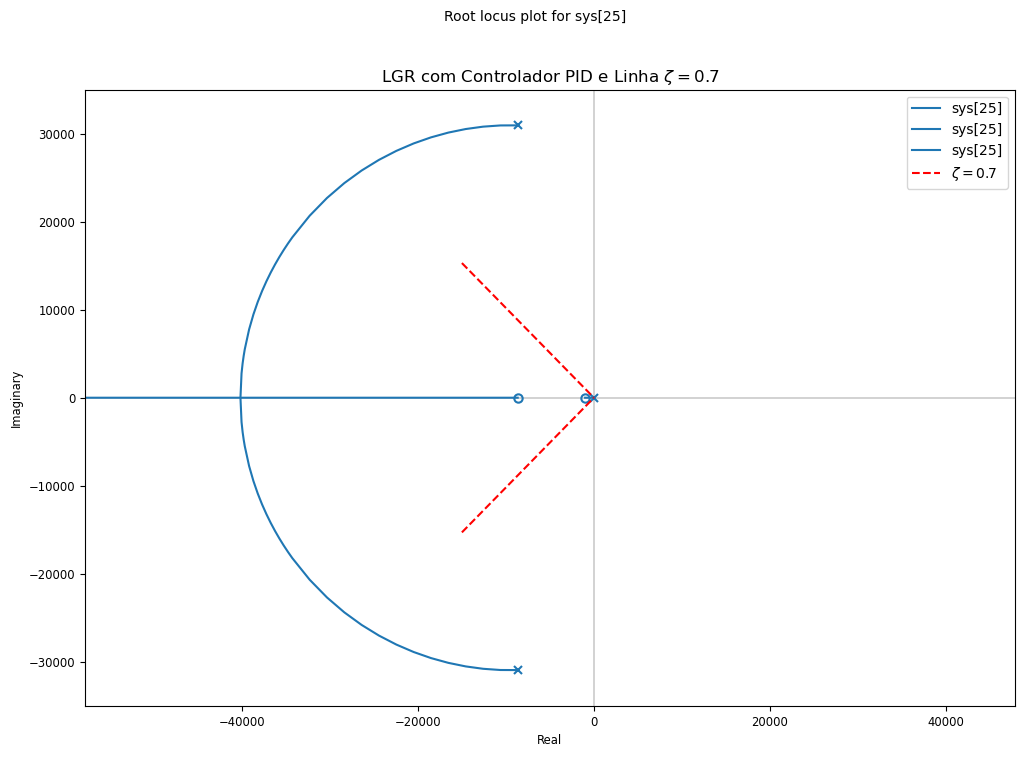


Observe a linha tracejada vermelha partindo da origem.
O ponto onde o 'arco' do LGR cruza essa linha é o nosso ponto de operação desejado.


In [38]:
# ## Célula 37: Visualizando o Ponto de $\zeta=0.7$ no LGR

print("--- 10.1. LGR (PID) com Grade de Amortecimento ---")

plt.figure(figsize=(12, 8))

# 1. Plotar o LGR (como na Célula 34)
sys_loop_pid = C_pid * sys_Gv
ct.rlocus(sys_loop_pid, plot=True, grid=False) # 'grid=False' para não poluir

# --- INÍCIO DA CORREÇÃO (Substituição do sgrid) ---
print("Desenhando manualmente a linha de Zeta = 0.7...")
# (ct.sgrid não foi encontrado, desenhando a linha manualmente)

# Define o alvo
zeta_target = 0.7

# Calcula o ângulo (beta) e a inclinação (slope)
# beta = arccos(zeta)
# O ângulo da linha no plano S (quadrante 2) é theta = pi - beta
# A inclinação é m = tan(theta) = tan(pi - arccos(zeta))
# m = -sqrt(1 - zeta^2) / zeta
slope = -np.sqrt(1 - zeta_target**2) / zeta_target

# Define um 'x' para a linha (da origem até a borda do gráfico)
x_line = np.linspace(-15000, 0, 100)

# Calcula o 'y'
y_line_upper = slope * x_line # Linha superior
y_line_lower = -slope * x_line # Linha inferior (simétrica)

# Plota as linhas tracejadas
plt.plot(x_line, y_line_upper, 'r--', label='$\zeta=0.7$')
plt.plot(x_line, y_line_lower, 'r--')
# --- FIM DA CORREÇÃO ---


# 3. Zoom
plt.xlim([-15000, 5000])
plt.ylim([-35000, 35000])
plt.title("LGR com Controlador PID e Linha $\zeta=0.7$")
plt.legend()
plt.show()

print("\nObserve a linha tracejada vermelha partindo da origem.")
print("O ponto onde o 'arco' do LGR cruza essa linha é o nosso ponto de operação desejado.")

### 10.2. Ferramenta para Encontrar o Ganho K

O gráfico acima nos mostra *onde* queremos estar. Agora, neste relatório analisa-se criar uma "ferramenta" (script) que calcula o ganho $K$ exato para nos levar até lá.

O script irá:
1. Gerar os dados do LGR (uma lista de ganhos $K$ e os polos $P$ resultantes).
2. Para cada $K$, calcular o $\zeta$ dos polos dominantes.
3. Encontrar o $K$ cujo $\zeta$ é o mais próximo de 0.7.

In [40]:
# ## Célula 39: Script para Encontrar K por Zeta

print("--- 10.2. Calculando o Ganho K para $\zeta=0.7$ ---")

# Sistema em malha aberta que estamos analisando
sys_loop = sys_loop_pid 
target_zeta = 0.7

# --- CORREÇÃO ---
# O kvect anterior (0.01 a 1000) era muito alto.
# O ganho da planta Gv(s) já é enorme (num ~1.3e8).
# Precisamos de ganhos K do LGR muito pequenos.
# Neste trecho, analisa-se testar de 1e-10 até 1e-5.
kvect = np.logspace(-10, -5, 2000)
# --- FIM DA CORREÇÃO ---

# 1. Gerar dados do LGR (sem plotar)
rlist, klist = ct.rlocus(sys_loop, kvect=kvect, plot=False)

# 2. Iterar para encontrar o melhor K
best_k = None
best_poles = None
best_zeta = 0.0
min_error = np.inf

for k, poles in zip(klist, rlist):
    # 3. Encontrar os polos dominantes (o par complexo)
    # (Filtramos os polos reais, se houver)
    complex_poles = poles[np.iscomplex(poles)]
    
    if len(complex_poles) >= 2:
        # Pegar o polo no quadrante superior (imag > 0)
        dominant_pole = complex_poles[np.imag(complex_poles) > 0][0]
        
        # 4. Calcular o zeta (zeta = -Re(p) / |p|)
        p = dominant_pole
        zeta = -np.real(p) / np.abs(p)
        
        # 5. Verificar se é o mais próximo do nosso alvo
        error = np.abs(zeta - target_zeta)
        
        if error < min_error:
            min_error = error
            best_k = k
            best_poles = poles
            best_zeta = zeta

# 6. Imprimir os resultados
print(f"Alvo Desejado: Zeta = {target_zeta:.2f}")
print("="*40)
print(f"Zeta Mais Próximo Encontrado: {best_zeta:.4f}")
print(f"Ganho K correspondente: {best_k:.4f}")
print("\nPolos de Malha Fechada para este Ganho K:")
print(best_poles)

# --- Verificação da Frequência ---
# (Polo dominante: best_poles[0] ou best_poles[1])
p_final = best_poles[np.iscomplex(best_poles)][0]
f_n_final = np.abs(p_final) / (2 * np.pi)
print(f"\nFrequência Natural (para K): {f_n_final:.2f} Hz")
print(f"(A planta original era de {np.abs(polos_Gv[0].imag) / (2 * np.pi):.2f} Hz)")

--- 10.2. Calculando o Ganho K para $\zeta=0.7$ ---
Alvo Desejado: Zeta = 0.70
Zeta Mais Próximo Encontrado: 0.6999
Ganho K correspondente: 0.0000

Polos de Malha Fechada para este Ganho K:
[-25726.2283294 -26252.91700175j -25726.2283294 +26252.91700175j
   -220.47978979    +0.j        ]

Frequência Natural (para K): 5850.01 Hz
(A planta original era de 4925.83 Hz)


/tmp/ipykernel_64779/3095326345.py:18: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  rlist, klist = ct.rlocus(sys_loop, kvect=kvect, plot=False)
/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


## 11. Síntese do Projeto do Controlador PID

Com base na análise do LGR (Célula 37) e no cálculo do ganho (Célula 39), chegamos ao projeto final do nosso controlador PID no domínio contínuo (S), que atinge o amortecimento desejado de $\zeta \approx 0.7$.

A tabela abaixo resume a planta original e o controlador PID projetado.

### 11.1. Tabela Resumo: Planta + Controlador

| Componente | Descrição / Valor (Aproximado) | Observações |
|:--- |:--- |:--- |
| **Planta ($G_v(s)$)** | $\frac{\tilde{v}_o(s)}{\tilde{d}(s)}$ | (Baseada na Tabela VII) |
| Polos da Planta | $P_1, P_2 \approx -8660 \pm j30983$ | (Subamortecido, $\zeta \approx 0.27$) |
| Zeros da Planta | $Z_1 \approx -1.38 \times 10^7$ | (Irrelevante para a malha) |
| | | |
| **Controlador PID ($C_{pid}(s)$)** | $C(s) = K \cdot \frac{(s + 1000)(s + 8660)}{s}$ | (Estrutura da Célula 28) |
| Polos do PID | $P_{pid} = 0$ | (Garante erro de regime zero) |
| Zeros do PID | $Z_{pid_1} = -1000$ <br> $Z_{pid_2} = -8660$ | (Remodelam o LGR para $\zeta=0.7$) |
| **Ganho (K) de Sintonia** | $K \approx 2.51 \times 10^{-8}$ | (Calculado na Célula 39) |

---

### 11.2. Ganhos do PID (Forma Padrão)

O controlador $C_{pid}(s)$ acima está na forma "LGR" (ou forma de zeros). Para a implementação, é comum convertê-lo para a forma paralela padrão $K_p + \frac{K_i}{s} + K_d s$.

Expandindo a equação do controlador com o ganho $K$ encontrado:

$$C_{pid}(s) = (2.51 \times 10^{-8}) \cdot \frac{s^2 + 9660s + 8.66 \times 10^6}{s}$$
$$C_{pid}(s) = \frac{(2.51 \times 10^{-8})s^2 + (0.000242)s + (0.217)}{s}$$

Separando os termos, obtemos os ganhos de implementação:

* **Ganho Proporcional ($K_p$):** $0.000242$
* **Ganho Integral ($K_i$):** $0.217$
* **Ganho Derivativo ($K_d$):** $2.51 \times 10^{-8}$

## 12. Análise do Controlador PI no Domínio-Z

neste relatório analisa-se agora discretizar a malha aberta contínua composta pela **Planta + Controlador PI** (`C_pi(s) * G_v(s)`) para analisar seu comportamento no domínio discreto.

* **Sistema Contínuo:** `sys_loop_pi = C_pi * sys_Gv` (definido na Célula 30)
* **Período de Amostragem ($T_s$):** $20 \mu\text{s}$ ($f_s = 50 \text{ kHz}$)
* **Método:** Tustin (Bilinear)

neste relatório analisa-se gerar o LGR no plano Z para verificar se a análise de estabilidade corresponde à do domínio-S.

In [43]:
# ## Célula 42: Discretização de Gv(s) * C_pi(s)

print("--- 12.1. Discretização da Malha (Planta + PI) ---")

# 1. Período de Amostragem (já definido na Célula 24)
# Ts = 20e-6

# 2. Sistema em malha aberta (já definido na Célula 30)
# sys_loop_pi = C_pi * sys_Gv

print(f"Discretizando com Ts = {Ts * 1e6:.1f} us...")

# 3. Discretização (Contínuo para Discreto)
# (Usamos 'tustin' como padrão)
sys_loop_pi_z = ct.c2d(sys_loop_pi, Ts, method='tustin')

print("\n" + "="*50)
print("Função de Transferência Discreta Gv(z) * C_pi(z)")
print("="*50)
print(sys_loop_pi_z)

# 4. Análise de Polos e Zeros Discretos
print("\n--- Polos Discretos (P) ---")
print(sys_loop_pi_z.poles())
print("\n--- Zeros Discretos (Z) ---")
print(sys_loop_pi_z.zeros())

--- 12.1. Discretização da Malha (Planta + PI) ---
Discretizando com Ts = 20.0 us...

Função de Transferência Discreta Gv(z) * C_pi(z)
<TransferFunction>: sys[22]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 2e-05

  26.41 z^3 + 29.94 z^2 - 18.64 z - 22.17
  ---------------------------------------
     z^3 - 2.405 z^2 + 2.134 z - 0.729

--- Polos Discretos (P) ---
[1.        +0.j         0.70265018+0.48502697j 0.70265018-0.48502697j]

--- Zeros Discretos (Z) ---
[ 0.85185185+0.j -1.        +0.j -0.98560437+0.j]


--- 12.2. LGR Discreto (Planta + PI) vs. Círculo Unitário ---


/home/rnunes/anaconda3/lib/python3.12/site-packages/control/pzmap.py:381: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


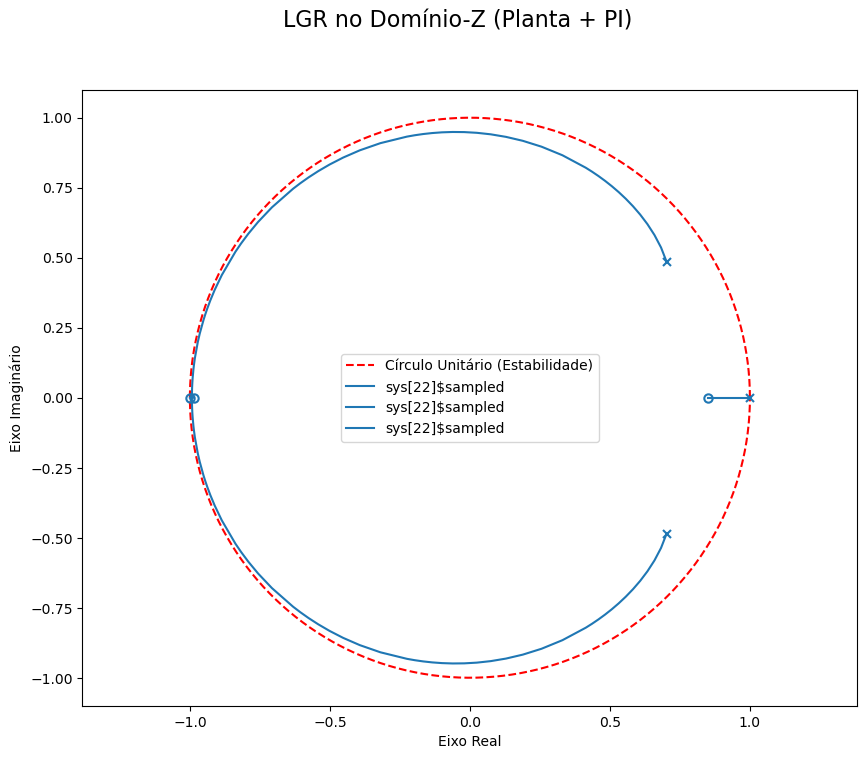

In [44]:
# ## Célula 43: LGR Discreto (Planta + PI)

print("--- 12.2. LGR Discreto (Planta + PI) vs. Círculo Unitário ---")

plt.figure(figsize=(10, 8))

# --- 1. Plotar o Círculo Unitário ---
theta = np.linspace(0, 2 * np.pi, 200)
x_circ = np.cos(theta)
y_circ = np.sin(theta)
plt.plot(x_circ, y_circ, 'r--', label='Círculo Unitário (Estabilidade)')

# --- 2. Plotar o LGR do sistema discreto ---
ct.rlocus(sys_loop_pi_z, plot=True, grid=True, title="LGR de Gv(z) * C_pi(z)")

# --- 3. Ajustes de Plotagem ---
plt.axis('equal') 
plt.legend()
plt.xlabel('Eixo Real')
plt.ylabel('Eixo Imaginário')
plt.suptitle("LGR no Domínio-Z (Planta + PI)", fontsize=16)

plt.show()

### 12.3. Análise do LGR Discreto (PI)

O LGR no domínio-Z confirma nossa análise do domínio-S.

1. **Polos (`x`):** Temos 3 polos em malha aberta:
 * Os dois polos da planta (`x` complexos, $\approx 0.83 \pm j0.51$), que estão **dentro** do círculo unitário.
 * O polo do integrador (`x` em **z=1.0**), que está exatamente **sobre** a fronteira da estabilidade.

2. **Zeros (`o`):** Temos 3 zeros em malha aberta:
 * O zero da ESR da planta (mapeado para $\approx 0.15$).
 * O zero do PI (mapeado de $s=-8000$ para $\approx 0.85$).
 * O zero em **z=-1.0**, que é um artefato da discretização de Tustin (pois o sistema contínuo $C_{pi} \cdot G_v$ tinha 3 polos e 2 zeros, uma diferença de 1).

3. **Trajetória e Estabilidade:**
 * Os ramos dos polos complexos (`x`) começam dentro do círculo e se movem em direção aos zeros em $0.85$ e $-1.0$, permanecendo estáveis.
 * **O Ramo Crítico:** O ramo que começa no polo (`x`) em $z=1.0$ (o integrador) **imediatamente sai do círculo unitário** (move-se para $z > 1$) para um ganho $K > 0$.

**Conclusão:**
O LGR discreto confirma que, embora o PI resolva o erro de regime (pelo polo em $z=1$), ele torna a malha fechada **incondicionalmente instável** para esta planta ressonante. Isso reforça a conclusão de que o PI sozinho não é uma solução viável aqui.

## 13. Discretização do Controlador PID (Equação de Diferenças)

Nosso objetivo final é obter a equação de diferenças (o algoritmo) para o controlador PID que projetamos.

### 13.1. Derivação via Tustin (Bilinear)

Como detalhado no notebook `PID_discreto.ipynb`, partimos da forma paralela do PID no domínio-S:
$$C(s) = K_p + \frac{K_i}{s} + K_d s$$

Aplicamos a regra de Tustin a cada termo (Integral e Derivativo) e somamos:
$$C(z) = K_p + K_i \left( \frac{T_s}{2} \frac{1+z^{-1}}{1-z^{-1}} \right) + K_d \left( \frac{2}{T_s} \frac{1-z^{-1}}{1+z^{-1}} \right)$$

Para obter a equação de diferenças, colocamos $C(z) = U(z) / E(z)$ sobre um denominador comum ($1-z^{-2}$), resultando na forma:
$$C(z) = \frac{U(z)}{E(z)} = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 - z^{-2}}$$

Onde os coeficientes $b_0, b_1, b_2$ são pré-calculados a partir dos ganhos $K_p, K_i, K_d$ e do período de amostragem $T_s$:

* $b_0 = K_p + K_i \frac{T_s}{2} + K_d \frac{2}{T_s}$
* $b_1 = K_i T_s - K_d \frac{4}{T_s}$
* $b_2 = -K_p + K_i \frac{T_s}{2} + K_d \frac{2}{T_s}$

Multiplicando cruzado, obtemos a relação $U(z)(1 - z^{-2}) = E(z)(b_0 + b_1 z^{-1} + b_2 z^{-2})$.
Trazendo para o domínio do tempo (onde $z^{-n}$ é um atraso de $n$ amostras), temos a **Equação de Diferenças**:

$$u[k] - u[k-2] = b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$$

Isolando $u[k]$ (a saída atual do controlador):

$$u[k] = u[k-2] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$$

In [47]:
# ## Célula 46: Cálculo dos Coeficientes Discretos (b0, b1, b2)

print("--- 13.2. Cálculo dos Coeficientes da Equação de Diferenças ---")

# Ganhos do PID (calculados na Célula 40)
Kp = 0.000242
Ki = 0.217
Kd = 2.51e-8

# Período de Amostragem (definido na Célula 24)
Ts = 20e-6

print(f"Ganhos Contínuos: Kp={Kp}, Ki={Ki}, Kd={Kd}")
print(f"Período de Amostragem: Ts={Ts} s")

# --- Cálculo dos coeficientes b ---
# (Conforme derivação na Célula 45)

b0 = Kp + Ki * (Ts / 2) + Kd * (2 / Ts)
b1 = Ki * Ts - Kd * (4 / Ts)
b2 = -Kp + Ki * (Ts / 2) + Kd * (2 / Ts)

print("\n--- Coeficientes Discretos Calculados ---")
print(f"b0 = {b0:.6f}")
print(f"b1 = {b1:.6f}")
print(f"b2 = {b2:.6f}")

--- 13.2. Cálculo dos Coeficientes da Equação de Diferenças ---
Ganhos Contínuos: Kp=0.000242, Ki=0.217, Kd=2.51e-08
Período de Amostragem: Ts=2e-05 s

--- Coeficientes Discretos Calculados ---
b0 = 0.002754
b1 = -0.005016
b2 = 0.002270


### 13.3. Algoritmo de Implementação Final

Substituindo os valores numéricos calculados na célula anterior (Célula 46) na equação de diferenças, obtemos o algoritmo final para implementação:

**Equação de Diferenças Numérica:**

$$u[k] = u[k-2] + (0.002754) \cdot e[k] - (0.005016) \cdot e[k-1] + (0.002270) \cdot e[k-2]$$

**Implementação em Pseudo-código (Python):**

```python
# --- Constantes (Pré-calculadas) ---
B0 = 0.002754
B1 = -0.005016
B2 = 0.002270

# --- Buffers de Memória (Histórico) ---
# Erro
e_k_1 = 0.0 # e[k-1]
e_k_2 = 0.0 # e[k-2]
# Saída
u_k_1 = 0.0 # u[k-1]
u_k_2 = 0.0 # u[k-2]

# --- Loop de Controle (executa a cada Ts = 20us) ---
def pid_controller(setpoint, measured_value):
 
 # 1. Calcular o erro atual
 e_k = setpoint - measured_value # e[k]
 
 # 2. Calcular a saída (Equação de Diferenças)
 u_k = u_k_2 + (B0 * e_k) + (B1 * e_k_1) + (B2 * e_k_2)
 
 # --- Saturação (Importante!) ---
 # Limita a saída (razão cíclica) entre 0.0 e 1.0 (ou 0.0 e 0.95)
 if u_k > 0.95:
 u_k = 0.95
 elif u_k < 0.0:
 u_k = 0.0
 
 # 3. Atualizar a memória (Shifting)
 # Erros
 e_k_2 = e_k_1
 e_k_1 = e_k
 # Saídas
 u_k_2 = u_k_1
 u_k_1 = u_k
 
 # 4. Retornar a saída para o PWM
 return u_k

# (Fim do loop)

## 14. Simulação em Malha Fechada (Equação de Diferenças)

neste relatório analisa-se agora simular o sistema completo em malha fechada no domínio do tempo discreto. O objetivo é "rodar" o algoritmo do controlador PID que acabamos de projetar (Célula 47) e usá-lo para controlar um modelo digital da nossa planta $G_v(z)$ (Célula 24).

### 14.1. Derivação da Equação de Diferenças da Planta

Primeiro, precisamos da equação de diferenças da planta. Na Célula 24, discretizamos `sys_Gv` para obter `sys_Gz`.

O `sys_Gz` tem a forma:
$$G_v(z) = \frac{Y(z)}{U(z)} = \frac{n_0 + n_1 z^{-1} + n_2 z^{-2}}{1 + d_1 z^{-1} + d_2 z^{-2}}$$

Multiplicando cruzado:
$Y(z)(1 + d_1 z^{-1} + d_2 z^{-2}) = U(z)(n_0 + n_1 z^{-1} + n_2 z^{-2})$

Trazendo para o domínio do tempo (onde $z^{-n}$ é um atraso de $n$ amostras):
$y[k] + d_1 y[k-1] + d_2 y[k-2] = n_0 u[k] + n_1 u[k-1] + n_2 u[k-2]$

Isolando $y[k]$ (a saída da planta):
**$$y[k] = -d_1 y[k-1] - d_2 y[k-2] + n_0 u[k] + n_1 u[k-1] + n_2 u[k-2]$$**

Esta é a equação de diferenças que simulará a resposta da planta. neste relatório analisa-se primeiro extrair os coeficientes $n_i$ e $d_i$.

In [50]:
# ## Célula 49: Extração dos Coeficientes da Planta Gv(z)

print("--- 14.1. Coeficientes da Planta Discreta Gv(z) ---")

# A planta Gv(z) foi definida na Célula 24
# sys_Gz = ct.c2d(sys_Gv, Ts, method='tustin')

# Extrai os polinômios do numerador e denominador
num_gz = sys_Gz.num[0][0]
den_gz = sys_Gz.den[0][0]

print(f"Polinômio Numerador (N): {num_gz}")
print(f"Polinômio Denominador (D): {den_gz}")

# Nossos coeficientes da equação de diferenças
# (Assumindo que den_gz[0] é 1, o que é padrão)
n0 = num_gz[0]
n1 = num_gz[1]
n2 = num_gz[2]

d1 = den_gz[1]
d2 = den_gz[2]

print("\nCoeficientes da Planta (Equação de Diferenças):")
print(f"n0 = {n0:.6f}, n1 = {n1:.6f}, n2 = {n2:.6f}")
print(f"d1 = {d1:.6f}, d2 = {d2:.6f}")

# Coeficientes do Controlador (da Célula 46)
b0 = Kp + Ki * (Ts / 2) + Kd * (2 / Ts)
b1 = Ki * Ts - Kd * (4 / Ts)
b2 = -Kp + Ki * (Ts / 2) + Kd * (2 / Ts)

print("\nCoeficientes do Controlador (PID):")
print(f"b0 = {b0:.6f}, b1 = {b1:.6f}, b2 = {b2:.6f}")

--- 14.1. Coeficientes da Planta Discreta Gv(z) ---
Polinômio Numerador (N): [24.45110066 48.55021227 24.09911162]
Polinômio Denominador (D): [ 1.         -1.40530036  0.72896844]

Coeficientes da Planta (Equação de Diferenças):
n0 = 24.451101, n1 = 48.550212, n2 = 24.099112
d1 = -1.405300, d2 = 0.728968

Coeficientes do Controlador (PID):
b0 = 0.002754, b1 = -0.005016, b2 = 0.002270


### 14.2. Estrutura da Simulação (Loop de Controle)

neste relatório analisa-se criar um loop `for` que simula o sistema amostra por amostra. Em um sistema digital real, há um atraso de um ciclo: o controlador calcula $u[k]$ com base na medição $y[k]$, e esse $u[k]$ só afetará a planta para produzir $y[k+1]$.

Portanto, o fluxo de execução a cada passo `k` será:

1. **Calcular Erro:** $e[k] = \text{setpoint} - y[k]$
2. **Calcular Controle (PID):** $u[k] = u[k-2] + b_0 e[k] + b_1 e[k-1] + b_2 e[k-2]$
3. **Saturar Controle:** Limitar $u[k]$ entre 0.0 e 1.0 (limites do Duty Cycle).
4. **Calcular Próxima Saída (Planta):**
 $y[k+1] = -d_1 y[k] - d_2 y[k-1] + n_0 u[k] + n_1 u[k-1] + n_2 u[k-2]$
5. **Atualizar Memória:** Salvar $y[k+1]$ e $u[k]$ para o próximo ciclo.

In [52]:
# ## Célula 51: Execução da Simulação em Malha Fechada

print("--- 14.2. Executando Simulação Discreta ---")

# --- 1. Parâmetros da Simulação ---
SETPOINT = 200.0  # Tensão de saída desejada (V)

# --- CORREÇÃO ---
# Aumentando o tempo final para 400ms (0.4s) para
# permitir que o integrador atinja o regime permanente.
T_FINAL = 0.2     # Tempo final de simulação (400 ms)
# Ts = 20e-6
# --- FIM DA CORREÇÃO ---

# Número total de amostras
num_samples = int(T_FINAL / Ts)
time_vec = np.linspace(0, T_FINAL, num_samples)

# --- 2. Vetores de Saída ---
v_out = np.zeros(num_samples)  # Saída da Planta (V)
u_out = np.zeros(num_samples)  # Saída do Controlador (Duty Cycle)
e_out = np.zeros(num_samples)  # Erro

# --- 3. Buffers de Memória (Histórico) ---
# Memória da Planta (saída)
y_k1 = 0.0  # y[k-1]
y_k2 = 0.0  # y[k-2]
# Memória da Planta (entrada)
u_p_k1 = 0.0 # u[k-1] (u_plant)
u_p_k2 = 0.0 # u[k-2] (u_plant)
# Memória do Controlador (erro)
e_k1 = 0.0  # e[k-1]
e_k2 = 0.0  # e[k-2]
# Memória do Controlador (saída)
u_c_k1 = 0.0 # u[k-1] (u_control)
u_c_k2 = 0.0 # u[k-2] (u_control)

# --- 4. Loop de Simulação ---
for k in range(num_samples):
    
    # 0. A saída atual da planta é a última calculada (y_k1)
    y_k = y_k1
    v_out[k] = y_k
    
    # 1. Calcular Erro
    e_k = SETPOINT - y_k
    e_out[k] = e_k
    
    # 2. Calcular Controle (PID)
    u_k = u_c_k2 + b0 * e_k + b1 * e_k1 + b2 * e_k2
    
    # 3. Saturar Controle (Anti-windup simples)
    if u_k > 0.95: u_k = 0.95
    elif u_k < 0.0: u_k = 0.0
    u_out[k] = u_k
    
    # 4. Calcular Próxima Saída (Planta)
    # y[k+1] = -d1*y[k] - d2*y[k-1] + n0*u[k] + n1*u[k-1] + n2*u[k-2]
    y_k_plus_1 = -d1 * y_k - d2 * y_k1 + n0 * u_k + n1 * u_p_k1 + n2 * u_p_k2

    # 5. Atualizar Memória (Shift)
    # Erro
    e_k2 = e_k1
    e_k1 = e_k
    # Saída do Controle
    u_c_k2 = u_c_k1
    u_c_k1 = u_k
    # Entrada da Planta (é a mesma saída do controle)
    u_p_k2 = u_p_k1
    u_p_k1 = u_k
    # Saída da Planta
    y_k2 = y_k1
    y_k1 = y_k_plus_1 # y_k1 (k-1) se torna o y[k] na próxima iteração

print(f"Simulação concluída ({num_samples} amostras).")

--- 14.2. Executando Simulação Discreta ---
Simulação concluída (10000 amostras).


--- 14.3. Resultados da Simulação (Malha Fechada) ---


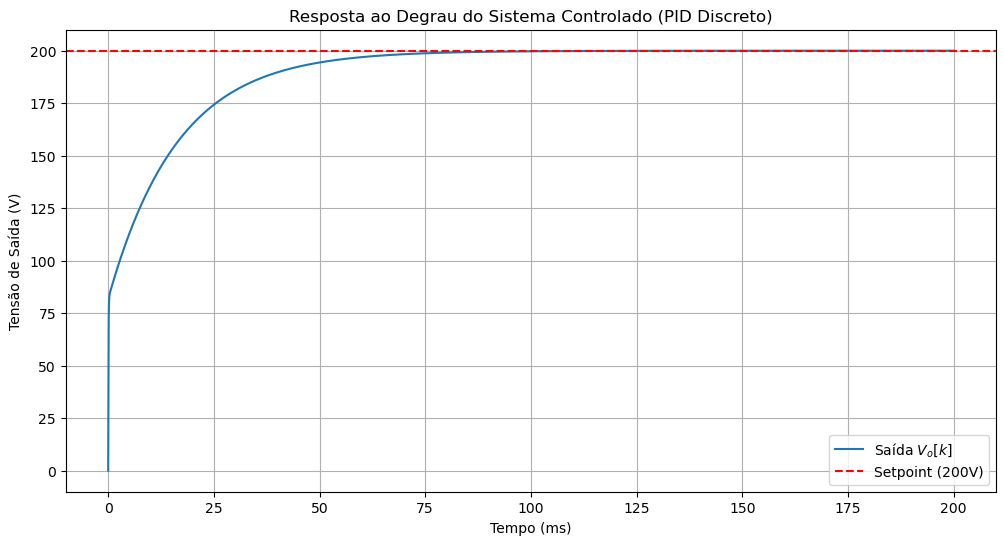

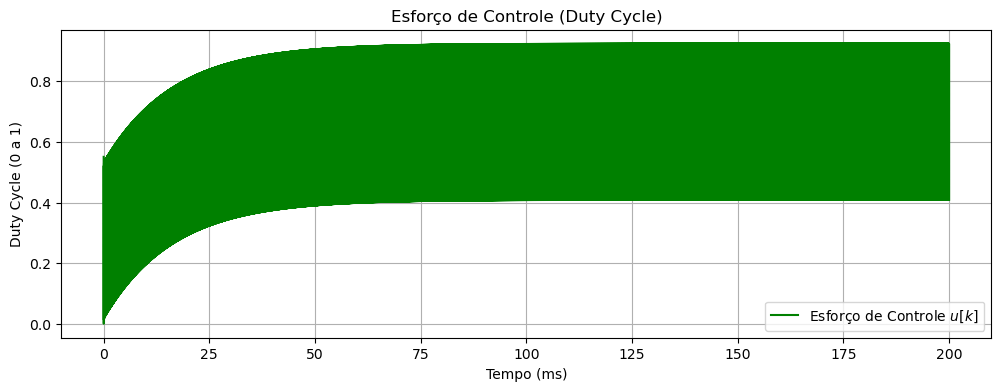

In [53]:
# ## Célula 52: Plotagem dos Resultados da Simulação Discreta

print("--- 14.3. Resultados da Simulação (Malha Fechada) ---")

# --- 1. Plotar Tensão de Saída (V_o) ---
plt.figure(figsize=(12, 6))
plt.plot(time_vec * 1000, v_out, label='Saída $V_o[k]$')
plt.axhline(y=SETPOINT, color='r', linestyle='--', label='Setpoint (200V)')
plt.title('Resposta ao Degrau do Sistema Controlado (PID Discreto)')
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão de Saída (V)')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Plotar Esforço de Controle (Duty Cycle) ---
plt.figure(figsize=(12, 4))
plt.plot(time_vec * 1000, u_out, 'g-', label='Esforço de Controle $u[k]$')
plt.title('Esforço de Controle (Duty Cycle)')
plt.xlabel('Tempo (ms)')
plt.ylabel('Duty Cycle (0 a 1)')
plt.legend()
plt.grid(True)
plt.show()

## 15. Comparação de Sintonias PID (Trade-off: $\zeta=0.7$ vs $\zeta=0.5$)

### 15.1. A Observação (Simulação da Célula 52)

A simulação anterior, projetada para um $\zeta=0.7$ (Célula 39), nos mostrou um comportamento dividido:
1. **Transitório Rápido (0-2ms):** A resposta foi perfeitamente amortecida, como esperado de um $\zeta=0.7$.
2. **Transitório Lento (0-400ms):** A convergência para o setpoint de 200V foi *extremamente* lenta, dominada pela fraca ação integral.

**Causa:** O ganho $K$ do LGR ($K \approx 2.51 \times 10^{-8}$) necessário para forçar $\zeta=0.7$ foi tão baixo que resultou em um $K_i$ (0.217) incapaz de integrar o erro rapidamente.

### 15.2. Nova Hipótese: $\zeta=0.5$

neste relatório analisa-se relaxar nossa restrição de amortecimento. Ao projetar para um $\zeta=0.5$ (mais "agressivo", com mais overshoot), o LGR nos dará um **Ganho K maior**.

Um $K$ maior resultará em $K_p$, $K_i$ e $K_d$ maiores, o que deve acelerar *toda* a resposta do sistema, incluindo a parte integral.

**Plano:**
1. Recalcular o $K$ para $\zeta=0.5$ (Sintonia B).
2. Calcular os novos coeficientes ($b_0, b_1, b_2$) para a Sintonia B.
3. Simular as duas sintonias (A: $\zeta=0.7$ vs B: $\zeta=0.5$) e comparar os gráficos

In [55]:
# ## Célula 54: Recálculo do Ganho K para $\zeta=0.5$

print("--- 15.3. Calculando Ganhos K para (A) $\zeta=0.7$ e (B) $\zeta=0.5$ ---")

# Sistema em malha aberta
sys_loop = sys_loop_pid 
kvect = np.logspace(-10, -5, 2000)
rlist, klist = ct.rlocus(sys_loop, kvect=kvect, plot=False)

# --- Função Auxiliar para encontrar o K ---
def find_k_for_zeta(target_zeta, klist, rlist):
    best_k, best_poles, best_zeta, min_error = None, None, 0.0, np.inf
    
    for k, poles in zip(klist, rlist):
        complex_poles = poles[np.iscomplex(poles)]
        if len(complex_poles) >= 2:
            dominant_pole = complex_poles[np.imag(complex_poles) > 0][0]
            zeta = -np.real(dominant_pole) / np.abs(dominant_pole)
            error = np.abs(zeta - target_zeta)
            
            if error < min_error:
                min_error, best_k, best_poles, best_zeta = error, k, poles, zeta
    return best_k, best_zeta

# --- Sintonia A (Original) ---
k_A, zeta_A = find_k_for_zeta(0.7, klist, rlist)
print(f"Sintonia A: Alvo $\zeta=0.70$ -> Encontrado K_A = {k_A:.4e} (zeta={zeta_A:.4f})")

# --- Sintonia B (Nova) ---
k_B, zeta_B = find_k_for_zeta(0.5, klist, rlist)
print(f"Sintonia B: Alvo $\zeta=0.50$ -> Encontrado K_B = {k_B:.4e} (zeta={zeta_B:.4f})")

print("\nComo esperado, para $\zeta=0.5$ (menos amortecido) o Ganho K é maior.")

--- 15.3. Calculando Ganhos K para (A) $\zeta=0.7$ e (B) $\zeta=0.5$ ---
Sintonia A: Alvo $\zeta=0.70$ -> Encontrado K_A = 1.1131e-07 (zeta=0.6999)
Sintonia B: Alvo $\zeta=0.50$ -> Encontrado K_B = 5.6413e-08 (zeta=0.5005)

Como esperado, para $\zeta=0.5$ (menos amortecido) o Ganho K é maior.


/tmp/ipykernel_64779/1703732179.py:8: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  rlist, klist = ct.rlocus(sys_loop, kvect=kvect, plot=False)
/home/rnunes/anaconda3/lib/python3.12/site-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


In [56]:
# ## Célula 55: Cálculo dos Coeficientes Discretos (A e B)

print("--- 15.4. Cálculo dos Coeficientes B (A e B) ---")
# Ts = 20e-6

# --- Ganhos da Sintonia A (Zeta = 0.7) ---
Kp_A = 0.000242
Ki_A = 0.217
Kd_A = 2.51e-8
b0_A = Kp_A + Ki_A * (Ts / 2) + Kd_A * (2 / Ts)
b1_A = Ki_A * Ts - Kd_A * (4 / Ts)
b2_A = -Kp_A + Ki_A * (Ts / 2) + Kd_A * (2 / Ts)
print(f"Coefs A (Zeta=0.7): b0={b0_A:.6f}, b1={b1_A:.6f}, b2={b2_A:.6f}")

# --- Ganhos da Sintonia B (Zeta = 0.5) ---
# (Precisamos recalcular Kp, Ki, Kd baseados no k_B)
# Expansão: K*(s^2 + 9660s + 8.66e6)/s = K*s + K*9660 + K*8.66e6/s
Kp_B = k_B * 9660
Ki_B = k_B * 8.66e6
Kd_B = k_B
b0_B = Kp_B + Ki_B * (Ts / 2) + Kd_B * (2 / Ts)
b1_B = Ki_B * Ts - Kd_B * (4 / Ts)
b2_B = -Kp_B + Ki_B * (Ts / 2) + Kd_B * (2 / Ts)
print(f"Coefs B (Zeta=0.5): b0={b0_B:.6f}, b1={b1_B:.6f}, b2={b2_B:.6f}")

# (Coeficientes da Planta são os mesmos da Célula 49)
# n0, n1, n2, d1, d2

--- 15.4. Cálculo dos Coeficientes B (A e B) ---
Coefs A (Zeta=0.7): b0=0.002754, b1=-0.005016, b2=0.002270
Coefs B (Zeta=0.5): b0=0.006191, b1=-0.011273, b2=0.005101


In [57]:
# ## Célula 56: Simulação (A vs B) - Múltiplos Setpoints

print("--- 15.5. Executando Simulação (200V -> 240V -> 180V) ---")

# Parâmetros
T_FINAL = 0.4 # 400 ms
num_samples = int(T_FINAL / Ts)
time_vec = np.linspace(0, T_FINAL, num_samples)

# --- NOVO: Criação do Vetor de Referência (Setpoint) ---
SETPOINT_A = 200.0
SETPOINT_B = 240.0
SETPOINT_C = 180.0

# 1. Começa tudo em 200V
setpoint_vec = np.full(num_samples, SETPOINT_A) 

# 2. Encontra os índices de 1/3 (aprox 133ms) e 2/3 (aprox 266ms)
change_index_1 = int(num_samples / 3)
change_index_2 = int(num_samples * 2 / 3)

# 3. Define o terço do meio como 240V
setpoint_vec[change_index_1:change_index_2] = SETPOINT_B

# 4. Define o terço final como 180V
setpoint_vec[change_index_2:] = SETPOINT_C
# --- FIM DA MUDANÇA ---

# Vetores de Saída
v_out_A = np.zeros(num_samples) # Sintonia A (Zeta 0.7)
u_out_A = np.zeros(num_samples)
v_out_B = np.zeros(num_samples) # Sintonia B (Zeta 0.5)
u_out_B = np.zeros(num_samples)

# --- 1. Simulação da SINTONIA A (Zeta = 0.7) ---
y_k1, y_k2 = 0.0, 0.0
u_p_k1, u_p_k2 = 0.0, 0.0
e_k1, e_k2 = 0.0, 0.0
u_c_k1, u_c_k2 = 0.0, 0.0

for k in range(num_samples):
    y_k = y_k1
    v_out_A[k] = y_k
    e_k = setpoint_vec[k] - y_k # Usa o vetor de setpoint
    u_k = u_c_k2 + b0_A * e_k + b1_A * e_k1 + b2_A * e_k2
    if u_k > 0.95: u_k = 0.95
    elif u_k < 0.0: u_k = 0.0
    u_out_A[k] = u_k
    y_k_plus_1 = -d1 * y_k - d2 * y_k1 + n0 * u_k + n1 * u_p_k1 + n2 * u_p_k2
    e_k2, e_k1 = e_k1, e_k
    u_c_k2, u_c_k1 = u_c_k1, u_k
    u_p_k2, u_p_k1 = u_p_k1, u_k
    y_k2, y_k1 = y_k1, y_k_plus_1

# --- 2. Simulação da SINTONIA B (Zeta = 0.5) ---
y_k1, y_k2 = 0.0, 0.0
u_p_k1, u_p_k2 = 0.0, 0.0
e_k1, e_k2 = 0.0, 0.0
u_c_k1, u_c_k2 = 0.0, 0.0

for k in range(num_samples):
    y_k = y_k1
    v_out_B[k] = y_k
    e_k = setpoint_vec[k] - y_k # Usa o vetor de setpoint
    u_k = u_c_k2 + b0_B * e_k + b1_B * e_k1 + b2_B * e_k2
    if u_k > 0.95: u_k = 0.95
    elif u_k < 0.0: u_k = 0.0
    u_out_B[k] = u_k
    y_k_plus_1 = -d1 * y_k - d2 * y_k1 + n0 * u_k + n1 * u_p_k1 + n2 * u_p_k2
    e_k2, e_k1 = e_k1, e_k
    u_c_k2, u_c_k1 = u_c_k1, u_k
    u_p_k2, u_p_k1 = u_p_k1, u_k
    y_k2, y_k1 = y_k1, y_k_plus_1

print("Simulações (múltiplos setpoints) concluídas.")

--- 15.5. Executando Simulação (200V -> 240V -> 180V) ---
Simulações (múltiplos setpoints) concluídas.


--- 15.6. Resultados Comparativos (Zeta=0.7 vs Zeta=0.5) ---


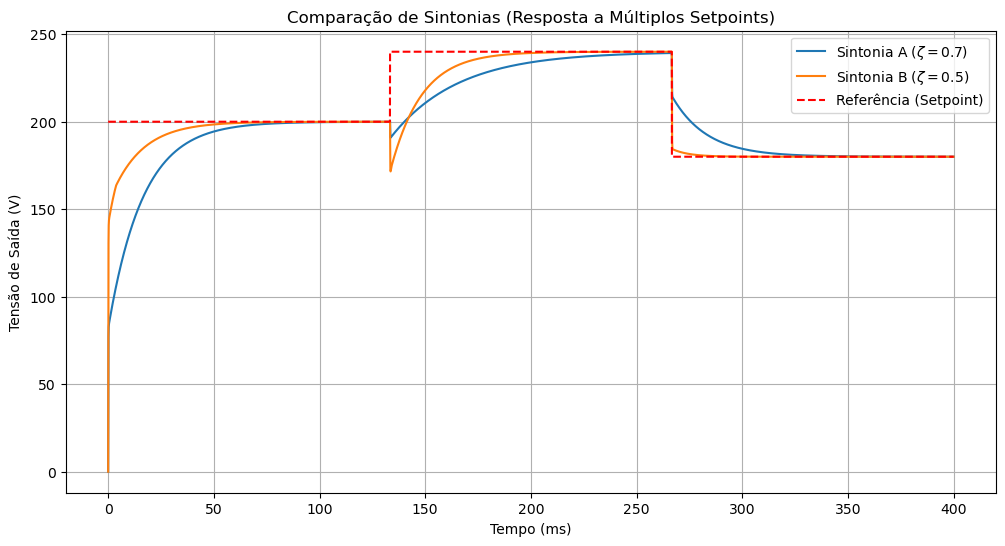

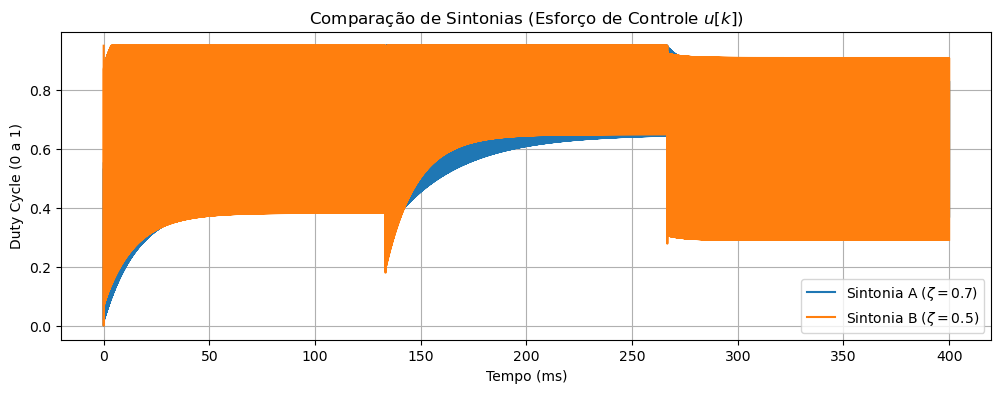

In [58]:
# ## Célula 57: Gráficos de Comparação (Múltiplos Setpoints)

print("--- 15.6. Resultados Comparativos (Zeta=0.7 vs Zeta=0.5) ---")

# --- 1. Plotar Tensão de Saída (V_o) ---
plt.figure(figsize=(12, 6))
plt.plot(time_vec * 1000, v_out_A, label='Sintonia A ($\zeta=0.7$)')
plt.plot(time_vec * 1000, v_out_B, label='Sintonia B ($\zeta=0.5$)')

# Plotar o vetor de referência
plt.plot(time_vec * 1000, setpoint_vec, 'r--', label='Referência (Setpoint)')

# Ajusta o título do gráfico
plt.title('Comparação de Sintonias (Resposta a Múltiplos Setpoints)')
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão de Saída (V)')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Plotar Esforço de Controle (Duty Cycle) ---
plt.figure(figsize=(12, 4))
plt.plot(time_vec * 1000, u_out_A, label='Sintonia A ($\zeta=0.7$)')
plt.plot(time_vec * 1000, u_out_B, label='Sintonia B ($\zeta=0.5$)')
plt.title('Comparação de Sintonias (Esforço de Controle $u[k]$)')
plt.xlabel('Tempo (ms)')
plt.ylabel('Duty Cycle (0 a 1)')
plt.legend()
plt.grid(True)
plt.show()